![header](header.jpg)

# HANDS ON SESSION FOR HIGH FREQUENCY RADAR DATA PROCESSING

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Run" and select "Run All Above Selected Cell".<br>
***

# Table of Contents
* [1. Introduction](#chapter1)
* [2. Setup](#chapter2)
    * [2.1. Python packages](#section_2_1)
    * [2.2. HFR network and station information](#section_2_2)
    * [2.3. HFR network specification](#section_2_3)
* [3. Assess search radius for radial combination](#chapter3)
    * [3.1. Current operational settings for radial combination](#section_3_1)
    * [3.2. Assessment of different search radius for radial combination](#section_3_2)
* [4. Verify QC tests](#chapter4)
    * [4.1. Total current fields](#section_4_1)
        * [4.1.1. Load data from the EU HFR NODE THREDDS Data Server](#sub_section_4_1_1)
        * [4.1.2. Evaluate the yearly percentage occurrence of "bad_data"](#sub_section_4_1_2)
    * [4.2. Radial current fields](#section_4_2)
        * [4.2.1. Load data from the EU HFR NODE THREDDS Data Server](#sub_section_4_2_1)
        * [4.2.2. Evaluate the yearly percentage occurrence of "bad_data"](#sub_section_4_2_2)

***

## 1. Introduction <a class="anchor" id="chapter1"></a>
[Go back to the "Table of Contents"](#Table-of-Contents)

This notebook focuses on providing basic routines for testing the processing and QC parameters for the operational workflow of the [European HFR Node](https://www.hfrnode.eu/). The operational routines of the European HFR Node are available on the GitHub repository [https://github.com/LorenzoCorgnati/EU_HFR_NODE_pyHFR](https://github.com/LorenzoCorgnati/EU_HFR_NODE_pyHFR).

For doing this you will provide sample radial and total files from the HFR network you manage. The sample files shall be saved in the `data` folder with the following folder tree: [1] `data/HFR-network/Radials_ruv/stationID` for radials measured by Codar systems, [2] `data/HFR-network/Radials_asc/stationID` for radials measured by WERA systems, [3] `data/HFR-network/Totals_tuv` for totals generated by Codar Radial Combine Suite, [4] `data/HFR-network/Totals_asc` for totals generated by WERA systems. 

The comprehensive information about HFR networks and stations are read from the operational database of the European HFR Node. In order to insert or modify the information stored in the database, please use the online [webform](https://webform.hfrnode.eu) of the European HFR Node.

<div class="alert alert-block alert-warning">
<b>WARNING</b>

***  
**Don't you have credentials yet to access the online webform of the European HFR Node?** <br>Please go [here](https://webform.hfrnode.eu) to set or recover them.
</div>

## 2. Setup <a class="anchor" id="chapter2"></a>
[Go back to the "Table of Contents"](#Table-of-Contents)

### 2.1. Python packages <a id="section_2_1"></a>

For the notebook to properly run we need to first load the next packages available from the Jupyter Notebook Ecosystem. Please run the `next cell`:

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import datetime as dt
import xarray as xr
import glob
import os
from radials import Radial
from totals import combineRadials
from calc import createLonLatGridFromBB, createLonLatGridFromBBwera, createLonLatGridFromTopLeftPointWera, roundToNearest20
from common import addBoundingBoxMetadata
from funcs import selectRadials, modifyNetworkDataFolders, modifyStationDataFolders, performRadialCombination
import pickle
import matplotlib.pyplot as plt
import zipfile
import numpy as np
from matplotlib import colors
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon
import geopy.distance
%matplotlib inline

### 2.2. HFR network and station information <a id="section_2_2"></a>

Now we need to load information and metadata about the HFR networks and their radial stations. Please run the `next cell`:

In [2]:
# Load network information into a dataframe
allNetworkData = pd.read_csv('allNetworkData.csv')
    
# Load station information into a dataframe
allStationData = pd.read_csv('allStationData.csv')

### 2.3. HFR network specification <a id="section_2_3"></a>

Now we need to specify the HFR network whose data are about to be processed. Please specify the ID of the HFR network you manage and run the `next cell`:

In [3]:
networkID = 'HFR-TirLig' # REPLACE THIS NETWORK WITH THE ID OF THE NETWORK YOU MANAGE

Now we load information and metadata about the specified HFR network and its stations. Please run the `next cell`:

In [4]:
# Network
networkData = allNetworkData.loc[allNetworkData['network_id'] == networkID]

# Stations
stationData = allStationData.loc[allStationData['network_id'] == networkID]

And now we display them. Please run the `next cell`:

In [5]:
# Network
networkData

network_id operational_from operational_to EDIOS_Series_id  EDMO_code                                      metadata_page                                              title                                            summary                                   institution_name  \
36  HFR-TirLig       2016-06-22            NaN      HFR-TirLig        134  https://thredds.hfrnode.eu:8443/thredds/NRTcur...  Near Real Time Surface Ocean Velocity by HFR-T...  The data set consists of maps of total velocit...  National Research Council - Institute of Marin...   

                                   citation_statement  ... EU_HFR_processing_flag connected_to_NRT  connected_to_REP  total_input_folder_path                        total_HFRnetCDF_folder_path                              total_mat_folder_path  TDS_root_url SDC_distribution_flag  \
36  Data collected and processed by CNR-ISMAR with...  ...                      1              1.0               1.0                      NaN  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/Tota...  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/Tota...           NaN                     1   

                                 SDC_OpenDAP_data_url                                    SDC_folder_path  
36  https://thredds.hfrnode.eu:8443/thredds/dodsC/...  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/SDC/...  

[1 rows x 44 columns]

In [6]:
# Stations
stationData

station_id  network_id   station_full_name  site_lon  site_lat operational_from operational_to  permanent_installation  oceanops_ref   wmo_code  ... radial_QC_radial_count_threshold  number_of_range_cells EU_HFR_processing_flag connected_to_NRT connected_to_REP                           radial_input_folder_path  \
118       LIGW  HFR-TirLig        Celle Ligure   8.56408   44.3465       2021-12-17            NaN                       1     6103569.0  6103569.0  ...                              200                     67                      1                1                1  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/Radi...   
143       MONT  HFR-TirLig  Monterosso al Mare   9.65333   44.1458       2016-06-22     2018-03-26                       0     6103578.0  6103578.0  ...                              200                     51                      1                0                1  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/Radi...   
164       PCOR  HFR-TirLig        Punta Corone   9.65930   44.1435       2018-04-04            NaN                       1     6103575.0  6103575.0  ...                              200                     51                      1                1                1  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/Radi...   
168       PFIN  HFR-TirLig           Portofino   9.21836   44.2987       2020-07-17            NaN                       1     6103570.0  6103570.0  ...                              200                     67                      1                1                1  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/Radi...   
251       TINO  HFR-TirLig      Isola del Tino   9.84922   44.0264       2016-08-04            NaN                       1     6103576.0  6103576.0  ...                              200                     51                      1                1                1  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/Radi...   
264       VIAR  HFR-TirLig           Viareggio  10.23730   43.8579       2018-09-13            NaN                       1     6103571.0  6103571.0  ...                              200                     51                      1                1                1  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/Radi...   

                          radial_HFRnetCDF_folder_path SDC_distribution_flag                               SDC_OpenDAP_data_url                                    SDC_folder_path  
118  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/Radi...                     1  https://thredds.hfrnode.eu:8443/thredds/dodsC/...  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/SDC/...  
143  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/Radi...                     1  https://thredds.hfrnode.eu:8443/thredds/dodsC/...  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/SDC/...  
164  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/Radi...                     1  https://thredds.hfrnode.eu:8443/thredds/dodsC/...  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/SDC/...  
168  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/Radi...                     1  https://thredds.hfrnode.eu:8443/thredds/dodsC/...  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/SDC/...  
251  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/Radi...                     1  https://thredds.hfrnode.eu:8443/thredds/dodsC/...  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/SDC/...  
264  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/Radi...                     1  https://thredds.hfrnode.eu:8443/thredds/dodsC/...  /home/radarcombine/EU_HFR_NODE/HFR-TirLig/SDC/...  

[6 rows x 42 columns]

## 3. Assess search radius for radial combination <a class="anchor" id="chapter3"></a>
[Go back to the "Table of Contents"](#Table-of-Contents)

### 3.1. Current operational settings for radial combination <a id="section_3_1"></a>

First of all, let's check the current operational parameters for radial combination, i.e. bounding box, grid resolution and search radius. Please run the `next cell`:

In [7]:
networkData[['geospatial_lon_min', 'geospatial_lon_max', 'geospatial_lat_min', 'geospatial_lat_max',
       'grid_resolution', 'combination_search_radius']]

geospatial_lon_min  geospatial_lon_max  geospatial_lat_min  geospatial_lat_max  grid_resolution  combination_search_radius
36                 7.5                10.5               43.25                44.5              2.0                        3.0

Now we select the available radials for performing the radial combination with the current operational settings. Please run the `next cell`:

In [8]:
# Modify folder paths for total files
networkData.at[networkData.index.values.astype(int)[0],'total_HFRnetCDF_folder_path'] = os.path.join('data',networkData.at[networkData.index.values.astype(int)[0],'network_id'],'Totals_nc')
# Modify folder paths for radial files
stationData = stationData.apply(lambda x: modifyStationDataFolders(x,'data'),axis=1)

# Select radials to be combined
radialsToBeProcessed = selectRadials(networkID, stationData)
radialsToBeProcessed

filename                          filepath  network_id station_id            timestamp             datetime       reception_date    filesize extension NRT_processed_flag NRT_processed_flag_integrated_network NRT_combined_flag
0    RDLi_LIGW_2022_09_01_2200.ruv  data/HFR-TirLig/Radials_ruv/LIGW  HFR-TirLig       LIGW  2022 09 01 22 00 00  2022-09-01 22:00:00  2024-08-29 11:38:24  580.994141      .ruv                  0                                     0                 0
1    RDLi_LIGW_2022_09_01_2100.ruv  data/HFR-TirLig/Radials_ruv/LIGW  HFR-TirLig       LIGW  2022 09 01 21 00 00  2022-09-01 21:00:00  2024-08-29 11:38:25  549.220703      .ruv                  0                                     0                 0
2    RDLi_LIGW_2022_09_01_2000.ruv  data/HFR-TirLig/Radials_ruv/LIGW  HFR-TirLig       LIGW  2022 09 01 20 00 00  2022-09-01 20:00:00  2024-08-29 11:38:25  566.638672      .ruv                  0                                     0                 0
3    RDLi_LIGW_2022_09_01_0400.ruv  data/HFR-TirLig/Radials_ruv/LIGW  HFR-TirLig       LIGW  2022 09 01 04 00 00  2022-09-01 04:00:00  2024-08-29 11:38:25  458.303711      .ruv                  0                                     0                 0
4    RDLi_LIGW_2022_09_01_0300.ruv  data/HFR-TirLig/Radials_ruv/LIGW  HFR-TirLig       LIGW  2022 09 01 03 00 00  2022-09-01 03:00:00  2024-08-29 11:38:25  490.267578      .ruv                  0                                     0                 0
..                             ...                               ...         ...        ...                  ...                  ...                  ...         ...       ...                ...                                   ...               ...
115  RDLm_VIAR_2022_09_01_1900.ruv  data/HFR-TirLig/Radials_ruv/VIAR  HFR-TirLig       VIAR  2022 09 01 19 00 00  2022-09-01 19:00:00  2024-08-29 11:38:28  105.186523      .ruv                  0                                     0                 0
116  RDLm_VIAR_2022_09_01_2000.ruv  data/HFR-TirLig/Radials_ruv/VIAR  HFR-TirLig       VIAR  2022 09 01 20 00 00  2022-09-01 20:00:00  2024-08-29 11:38:28   97.378906      .ruv                  0                                     0                 0
117  RDLm_VIAR_2022_09_01_2200.ruv  data/HFR-TirLig/Radials_ruv/VIAR  HFR-TirLig       VIAR  2022 09 01 22 00 00  2022-09-01 22:00:00  2024-08-29 11:38:28   95.093750      .ruv                  0                                     0                 0
118  RDLm_VIAR_2022_09_01_2300.ruv  data/HFR-TirLig/Radials_ruv/VIAR  HFR-TirLig       VIAR  2022 09 01 23 00 00  2022-09-01 23:00:00  2024-08-29 11:38:28   96.617188      .ruv                  0                                     0                 0
119  RDLm_VIAR_2022_09_01_0000.ruv  data/HFR-TirLig/Radials_ruv/VIAR  HFR-TirLig       VIAR  2022 09 01 00 00 00  2022-09-01 00:00:00  2024-08-29 11:38:28  107.852539      .ruv                  0                                     0                 0

[120 rows x 12 columns]

Now let's create a total velocity field by combining the first available radials with the current operational settings. Please run the `next cell`:

In [9]:
# Round datetime according to temporal resolution(i.e. to the closest 20-minute time) 
if networkID == 'HFR-COSYNA':
    radialsToBeProcessed['datetime'] = radialsToBeProcessed['datetime'].apply(roundToNearest20)
            
# Get the first available radials
groupedRad = radialsToBeProcessed[radialsToBeProcessed['datetime']==radialsToBeProcessed['datetime'].min()]

# Add Radial objects to the DataFrame
groupedRad['Radial'] = (groupedRad.filepath + '/' + groupedRad.filename).apply(lambda x: Radial(x))

# Add metadata related to bounding box
lonMin = networkData.iloc[0]['geospatial_lon_min']
lonMax = networkData.iloc[0]['geospatial_lon_max']
latMin = networkData.iloc[0]['geospatial_lat_min']
latMax = networkData.iloc[0]['geospatial_lat_max']
gridRes = networkData.iloc[0]['grid_resolution']
groupedRad['Radial'] = groupedRad['Radial'].apply(lambda x: addBoundingBoxMetadata(x,lonMin,lonMax,latMin,latMax,gridRes))

# Rename indices with site codes
indexMapper = dict(zip(groupedRad.index.values.tolist(),groupedRad['station_id'].to_list()))
groupedRad.rename(index=indexMapper,inplace=True) 

groupedRad

filename                          filepath  network_id station_id            timestamp             datetime       reception_date    filesize extension NRT_processed_flag NRT_processed_flag_integrated_network NRT_combined_flag                                   Radial
LIGW  RDLi_LIGW_2022_09_01_0000.ruv  data/HFR-TirLig/Radials_ruv/LIGW  HFR-TirLig       LIGW  2022 09 01 00 00 00  2022-09-01 00:00:00  2024-08-29 11:38:25  506.729492      .ruv                  0                                     0                 0  <Radial: RDLi_LIGW_2022_09_01_0000.ruv>
PCOR  RDLm_PCOR_2022_09_01_0000.ruv  data/HFR-TirLig/Radials_ruv/PCOR  HFR-TirLig       PCOR  2022 09 01 00 00 00  2022-09-01 00:00:00  2024-08-29 11:38:26  149.004883      .ruv                  0                                     0                 0  <Radial: RDLm_PCOR_2022_09_01_0000.ruv>
PFIN  RDLm_PFIN_2022_09_01_0000.ruv  data/HFR-TirLig/Radials_ruv/PFIN  HFR-TirLig       PFIN  2022 09 01 00 00 00  2022-09-01 00:00:00  2024-08-29 11:38:27  282.130859      .ruv                  0                                     0                 0  <Radial: RDLm_PFIN_2022_09_01_0000.ruv>
TINO  RDLm_TINO_2022_09_01_0000.ruv  data/HFR-TirLig/Radials_ruv/TINO  HFR-TirLig       TINO  2022 09 01 00 00 00  2022-09-01 00:00:00  2024-08-29 11:38:27  411.799805      .ruv                  0                                     0                 0  <Radial: RDLm_TINO_2022_09_01_0000.ruv>
VIAR  RDLm_VIAR_2022_09_01_0000.ruv  data/HFR-TirLig/Radials_ruv/VIAR  HFR-TirLig       VIAR  2022 09 01 00 00 00  2022-09-01 00:00:00  2024-08-29 11:38:28  107.852539      .ruv                  0                                     0                 0  <Radial: RDLm_VIAR_2022_09_01_0000.ruv>

In [10]:
# Perform radial combination
if len(groupedRad) > 1:
    T = performRadialCombination(groupedRad,networkData)
    T.data

Now we'll plot the total velocity field obtained by the radial combination. Please run the `next cell`:

Text(0.5, 1.0, '2022-09-01 00:00 - Search radius = 3.0 km')

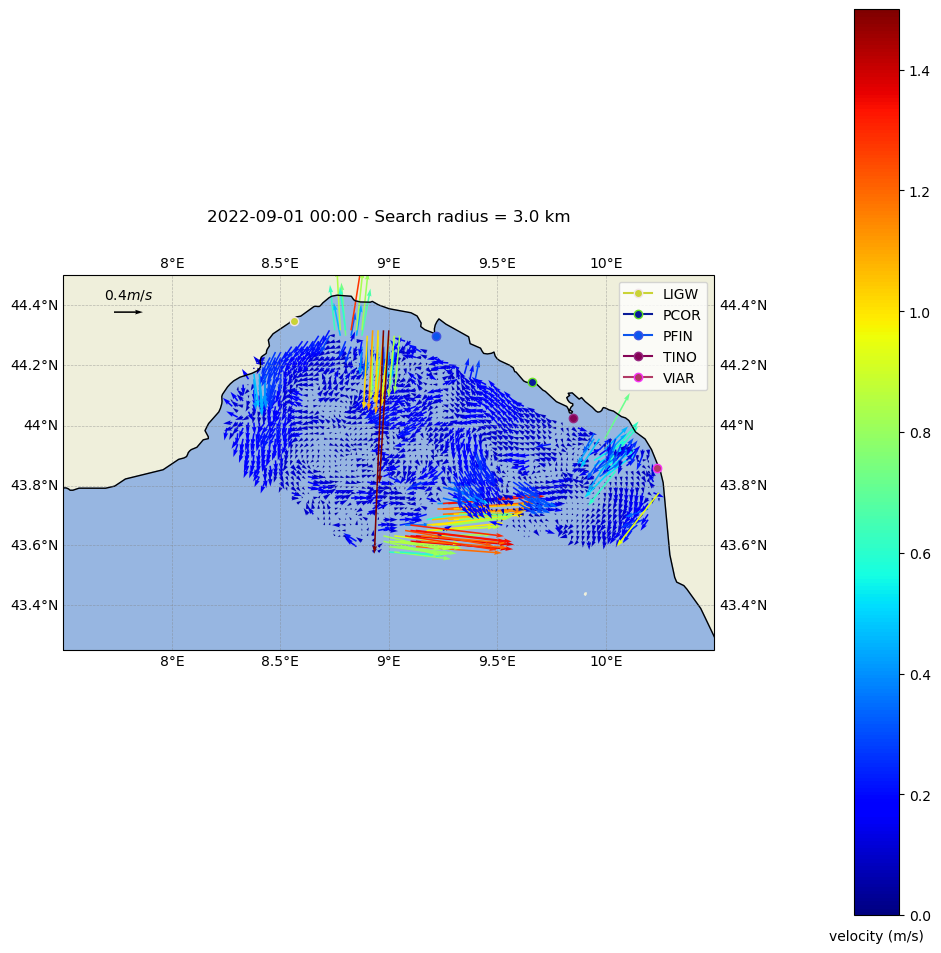

In [11]:
cmap = 'jet'
norm = colors.Normalize(vmin=0, vmax=1.5)

extent = [float(T.metadata['BBminLongitude'].split()[0]),float(T.metadata['BBmaxLongitude'].split()[0]),float(T.metadata['BBminLatitude'].split()[0]),float(T.metadata['BBmaxLatitude'].split()[0])] #minX,maxX,#minY,maxY

plt.figure(num=None, figsize=(12, 12), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Mercator())# Map projection
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') #adding grid lines

#plotting antennas
for Rindex, site in T.site_source.iterrows():
    plt.plot(site['Lon'], site['Lat'], color=np.random.rand(3,), markeredgecolor=np.random.rand(3,), marker='o',transform=ccrs.Geodetic(),label=site['Name'])#add points
    
ax.legend()#add legend
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent(extent)#personalized limits

# Scale the velocity component variables
if T.is_wera:
    u = T.data.VELU
    v = T.data.VELV
else:
    u = T.data.VELU / 100        # CODAR velocities are in cm/s
    v = T.data.VELV / 100        # CODAR velocities are in cm/s

x,y,U,V = T.data['LOND'].values,T.data['LATD'].values,u.values,v.values

m = (U ** 2 + V ** 2) ** 0.5

Q=ax.quiver(x, y, U, V, m, transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm, scale=9)
#arrow reference
ax.quiverkey(Q, 0.1, 0.9, 0.4, r'$0.4 m/s$',fontproperties={'weight': 'bold'})
#colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
plt.colorbar(sm,ax=ax, orientation='vertical', pad=0.15).ax.set_xlabel('velocity (m/s)', labelpad=10, )

plt.title(T.time.strftime('%Y-%m-%d %H:%M') + ' - Search radius = ' + T.metadata['AveragingRadius'], pad=25)

### 3.2. Assessment of different settings for radial combination <a id="section_3_2"></a>

Now we'll check different search radius for radial combination in order to guide you in selecting the optimal one.
We'll try 4 different values for the search radius: [0.5, 1, 1.5, 3] * grid resolution.
Please run the `next cell`:

In [12]:
searchRadius = np.multiply([0.5, 1, 1.5, 3], networkData.at[networkData.index.values.astype(int)[0],'grid_resolution'])
print('Search radius = ' + str(searchRadius) + ' km')

Search radius = [1. 2. 3. 6.] km


Let's create the 4 total velocity fields by using the different search radius. Please run the `next cell`:

In [13]:
# Store the current operational search radius
operationalSearchRadius = networkData.at[networkData.index.values.astype(int)[0],'combination_search_radius']

# Create an empty list for containing the four totals
Tot = []

# Loop through the search radius array
for sR in searchRadius:
    # Assign the search radius
    networkData.at[networkData.index.values.astype(int)[0],'combination_search_radius'] = sR
    
    
    # Perform the radial combination
    Tot.append(performRadialCombination(groupedRad,networkData))
    
# Restore the current operational search radius
networkData.at[networkData.index.values.astype(int)[0],'combination_search_radius'] = operationalSearchRadius
    

Now we'll plot the 4 total velocity fields obtained by using the different search radius for comparison. Please run the `next cell`:

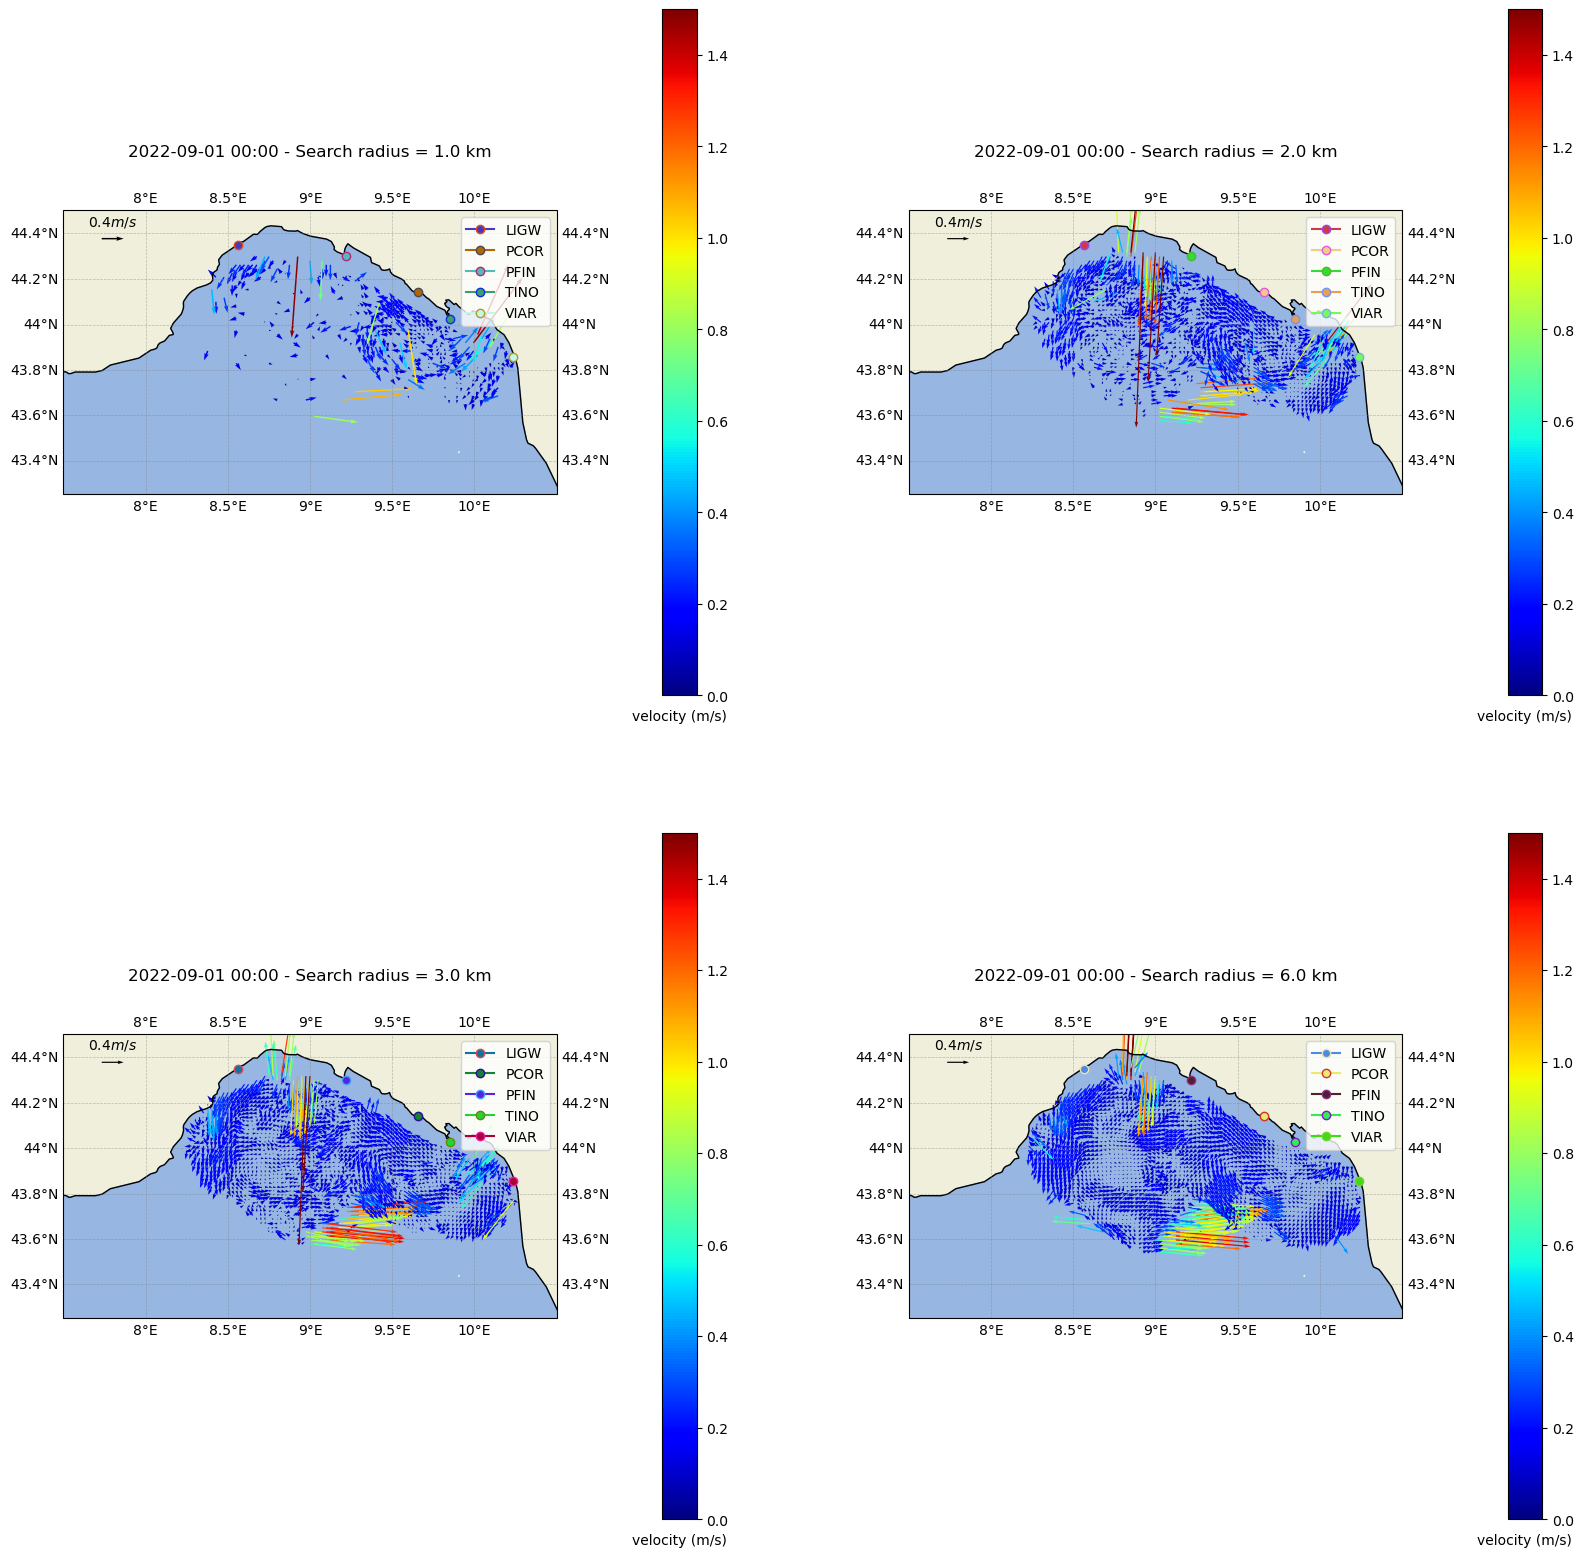

In [14]:
cmap = 'jet'
norm = colors.Normalize(vmin=0, vmax=1.5)

fig, axs = plt.subplots(2, 2, subplot_kw={'projection': ccrs.Mercator()}, figsize=(20, 20), dpi=100, facecolor='w', edgecolor='k')

for i, ax in enumerate(axs.flat):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') #adding grid lines
    
    #plotting antennas
    for Rindex, site in Tot[i].site_source.iterrows():
        ax.plot(site['Lon'], site['Lat'], color=np.random.rand(3,), markeredgecolor=np.random.rand(3,), marker='o',transform=ccrs.Geodetic(),label=site['Name'])#add points
    
    extent = [float(Tot[i].metadata['BBminLongitude'].split()[0]),float(Tot[i].metadata['BBmaxLongitude'].split()[0]),float(Tot[i].metadata['BBminLatitude'].split()[0]),float(Tot[i].metadata['BBmaxLatitude'].split()[0])] #minX,maxX,#minY,maxY
    
    ax.legend()#add legend
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent(extent)#personalized limits
    
    # Scale the velocity component variables
    if Tot[i].is_wera:
        u = Tot[i].data.VELU
        v = Tot[i].data.VELV
    else:
        u = Tot[i].data.VELU / 100        # CODAR velocities are in cm/s
        v = Tot[i].data.VELV / 100        # CODAR velocities are in cm/s

    x,y,U,V = Tot[i].data['LOND'].values,Tot[i].data['LATD'].values,u.values,v.values
    
    m = (U ** 2 + V ** 2) ** 0.5

    Q=ax.quiver(x, y, U, V, m, transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm, scale=9)
    #arrow reference
    ax.quiverkey(Q, 0.1, 0.9, 0.4, r'$0.4 m/s$',fontproperties={'weight': 'bold'})
    #colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    plt.colorbar(sm,ax=ax, orientation='vertical', pad=0.15).ax.set_xlabel('velocity (m/s)', labelpad=10, )

    ax.set_title(Tot[i].time.strftime('%Y-%m-%d %H:%M') + ' - Search radius = ' + Tot[i].metadata['AveragingRadius'], pad=25)


<div class="alert alert-block alert-warning">
<b>SET YOUR OPTIMAL SEARCH RADIUS</b>

***  
**Based on this exercise, you can now choose the optimal search radius for your HFR network. The rule of thumb is to set it 1.5 times the grid resolution.** <br>You can do it in the next cells by setting the value you want to try and then running the following cells for creating the total field and plot it.
</div>

Let's set a search radius. Please run the `next cell`:

In [15]:
yourSearchRadius = 3.5 # REPLACE THIS VALUE WITH YOUR CHOICE
print('Search radius = ' + str(yourSearchRadius) + ' km')

Search radius = 3.5 km


Now let's create the total field. Please run the `next cell`:

In [16]:
# Assign your search radius
networkData.at[networkData.index.values.astype(int)[0],'combination_search_radius'] = yourSearchRadius

# Perform the radial combination
yourT = performRadialCombination(groupedRad,networkData)

And plot it. Please run the `next cell`:

Text(0.5, 1.0, '2022-09-01 00:00 - Search radius = 3.5 km')

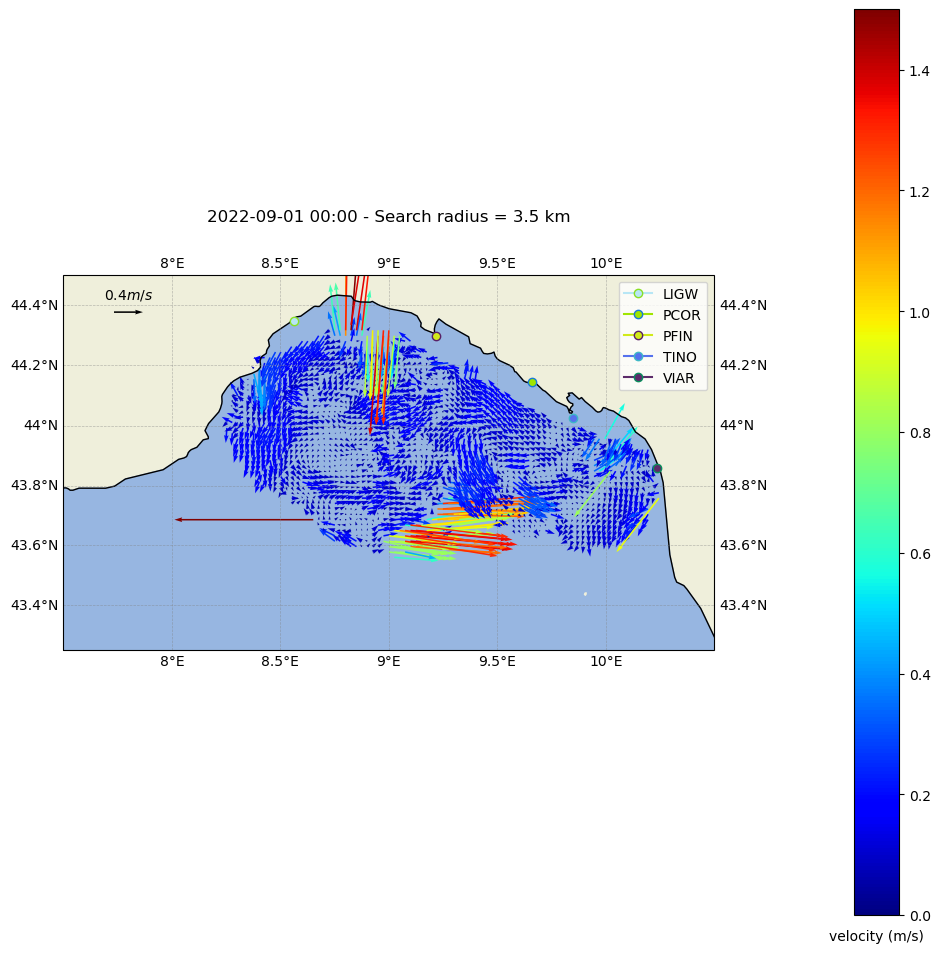

In [17]:
cmap = 'jet'
norm = colors.Normalize(vmin=0, vmax=1.5)

extent = [float(yourT.metadata['BBminLongitude'].split()[0]),float(yourT.metadata['BBmaxLongitude'].split()[0]),float(yourT.metadata['BBminLatitude'].split()[0]),float(yourT.metadata['BBmaxLatitude'].split()[0])] #minX,maxX,#minY,maxY

plt.figure(num=None, figsize=(12, 12), dpi=100, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Mercator())# Map projection
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') #adding grid lines

#plotting antennas
for Rindex, site in yourT.site_source.iterrows():
    plt.plot(site['Lon'], site['Lat'], color=np.random.rand(3,), markeredgecolor=np.random.rand(3,), marker='o',transform=ccrs.Geodetic(),label=site['Name'])#add points
    
ax.legend()#add legend
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
ax.add_feature(cfeature.COASTLINE)
ax.set_extent(extent)#personalized limits

# Scale the velocity component variables
if yourT.is_wera:
    u = yourT.data.VELU
    v = yourT.data.VELV
else:
    u = yourT.data.VELU / 100        # CODAR velocities are in cm/s
    v = yourT.data.VELV / 100        # CODAR velocities are in cm/s

x,y,U,V = yourT.data['LOND'].values,yourT.data['LATD'].values,u.values,v.values

m = (U ** 2 + V ** 2) ** 0.5

Q=ax.quiver(x, y, U, V, m, transform=cartopy.crs.PlateCarree(), cmap=cmap, norm=norm, scale=9)
#arrow reference
ax.quiverkey(Q, 0.1, 0.9, 0.4, r'$0.4 m/s$',fontproperties={'weight': 'bold'})
#colorbar
sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
plt.colorbar(sm,ax=ax, orientation='vertical', pad=0.15).ax.set_xlabel('velocity (m/s)', labelpad=10, )

plt.title(yourT.time.strftime('%Y-%m-%d %H:%M') + ' - Search radius = ' + yourT.metadata['AveragingRadius'], pad=25)

## 4. Verify QC tests <a class="anchor" id="chapter4"></a>
[Go back to the "Table of Contents"](#Table-of-Contents)

### 4.1. Total current fields <a id="section_4_1"></a>

In this section we'll check the impact of the QC tests as they are operationally applied to the total velocity field data produced by your HFR network. In particular, the yearly percentage occurrence of "bad_data" flags on the total velocity fields will be displayed per each QC test, in order to allow you to assess how effective the thresholds you chose for the QC tests are.

#### 4.1.1. Load data from the EU HFR NODE THREDDS Data Server <a id="sub_section_4_1_1"></a>

Now we load the total velocity dataset for year 2023 of your HFR network from the EU HFR NODE THREDDS Data Server. Please run the `next cell`:

In [18]:
# Set the year to be loaded
year = 2023

# Set the yearly temporal extent
tStart = dt.datetime.strptime(str(year) + '-01-01 00:00:00','%Y-%m-%d %H:%M:%S')
tEnd = dt.datetime.strptime(str(year) + '-12-31 23:59:00','%Y-%m-%d %H:%M:%S')

# Get the TDS URL of the dataset
OpenDAPdataUrl = networkData.at[networkData.index.values.astype(int)[0],'SDC_OpenDAP_data_url']

# Read aggregated total dataset from THREDDS catalog via OpenDAP
ds = xr.open_dataset(OpenDAPdataUrl, decode_times=True).sel(TIME=slice(tStart,tEnd))
ds


<xarray.Dataset>
Dimensions:           (DEPTH: 1, LATITUDE: 70, LONGITUDE: 121, MAXINST: 50, MAXSITE: 150, REFMAX: 1, TIME: 7681)
Coordinates:
  * DEPTH             (DEPTH) float32 0.0
  * LATITUDE          (LATITUDE) float32 43.25 43.27 43.29 ... 44.46 44.48 44.5
  * LONGITUDE         (LONGITUDE) float32 7.507 7.532 7.557 ... 10.47 10.49
  * TIME              (TIME) datetime64[ns] 2023-01-16T11:00:00 ... 2023-12-3...
Dimensions without coordinates: MAXINST, MAXSITE, REFMAX
Data variables: (12/29)
    crs               int16 ...
    NARX              (TIME, MAXSITE) float32 ...
    NATX              (TIME, MAXSITE) float32 ...
    SLTR              (TIME, MAXSITE) float64 ...
    SLNR              (TIME, MAXSITE) float64 ...
    SLTT              (TIME, MAXSITE) float64 ...
    ...                ...
    EWCT              (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    NSCT              (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    EWCS              (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    NSCS              (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
    CCOV              (TIME, DEPTH, LATITUDE, LONGITUDE) float64 ...
    POSITION_QC       (TIME, DEPTH, LATITUDE, LONGITUDE) float32 ...
Attributes: (12/83)
    site_code:                       HFR-TirLig
    platform_code:                   HFR-TirLig-Total
    data_mode:                       R
    doa_estimation_method:           LIGW: Direction Finding, MONT: Direction...
    calibration_type:                LIGW: APM, MONT: APM, PCOR: APM, PFIN: A...
    last_calibration_date:           LIGW: 2018-12-06T00:00:00Z, MONT: 2016-0...
    ...                              ...
    doi:                             
    software_name:                   EU_HFR_NODE_NRTprocessor
    software_version:                v3
    references:                      Recommendation Report 2 on improved comm...
    DODS.strlen:                     146
    DODS.dimName:                    STRING146

#### 4.1.2. Evaluate the yearly percentage occurrence of "bad_data" <a id="sub_section_4_1_2"></a>

First of all let's check the current operational thresholds for total velocity fields QC tests, i.e. Temporal derivative, GDOP test, Data density and Velocity test. Please run the `next cell`:

In [19]:
networkData[['total_QC_variance_threshold', 'total_QC_GDOP_threshold', 'total_QC_data_density_threshold', 'total_QC_velocity_threshold']]

total_QC_variance_threshold  total_QC_GDOP_threshold  total_QC_data_density_threshold  total_QC_velocity_threshold
36                          1.0                      2.0                                3                          1.2

Now we'll evaluate the yearly percentage occurrence of "bad_data" flags on the total velocity fields per each QC test. Please run the `next cell`:

In [20]:
# Create the list of interested QC variables present in the dataset
qcV = ['VART_QC','GDOP_QC','DDNS_QC','CSPD_QC']

# Create an empty list for containing the percentage occurrence matrices for the QC variables
percOcc = []
for v in qcV:
    # Create a mask for non-NaN values
    nonNanMask = ~np.isnan(ds[v])

    # Count occurrences of value 4 along the TIME dimension
    count4 = (ds[v] == 4).sum(dim='TIME')

    # Count non-NaN occurrences along the TIME dimension
    countNonNan = nonNanMask.sum(dim='TIME')

    # Divide the counts to get the percentage occurrence
    percOcc.append((count4 / countNonNan) *100)


Here we'll plot the yearly percentage occurrence of "bad_data" flags on the total velocity fields per each QC test. Please run the `next cell`:

Text(0.5, 0.98, 'Total current fields QC tests')

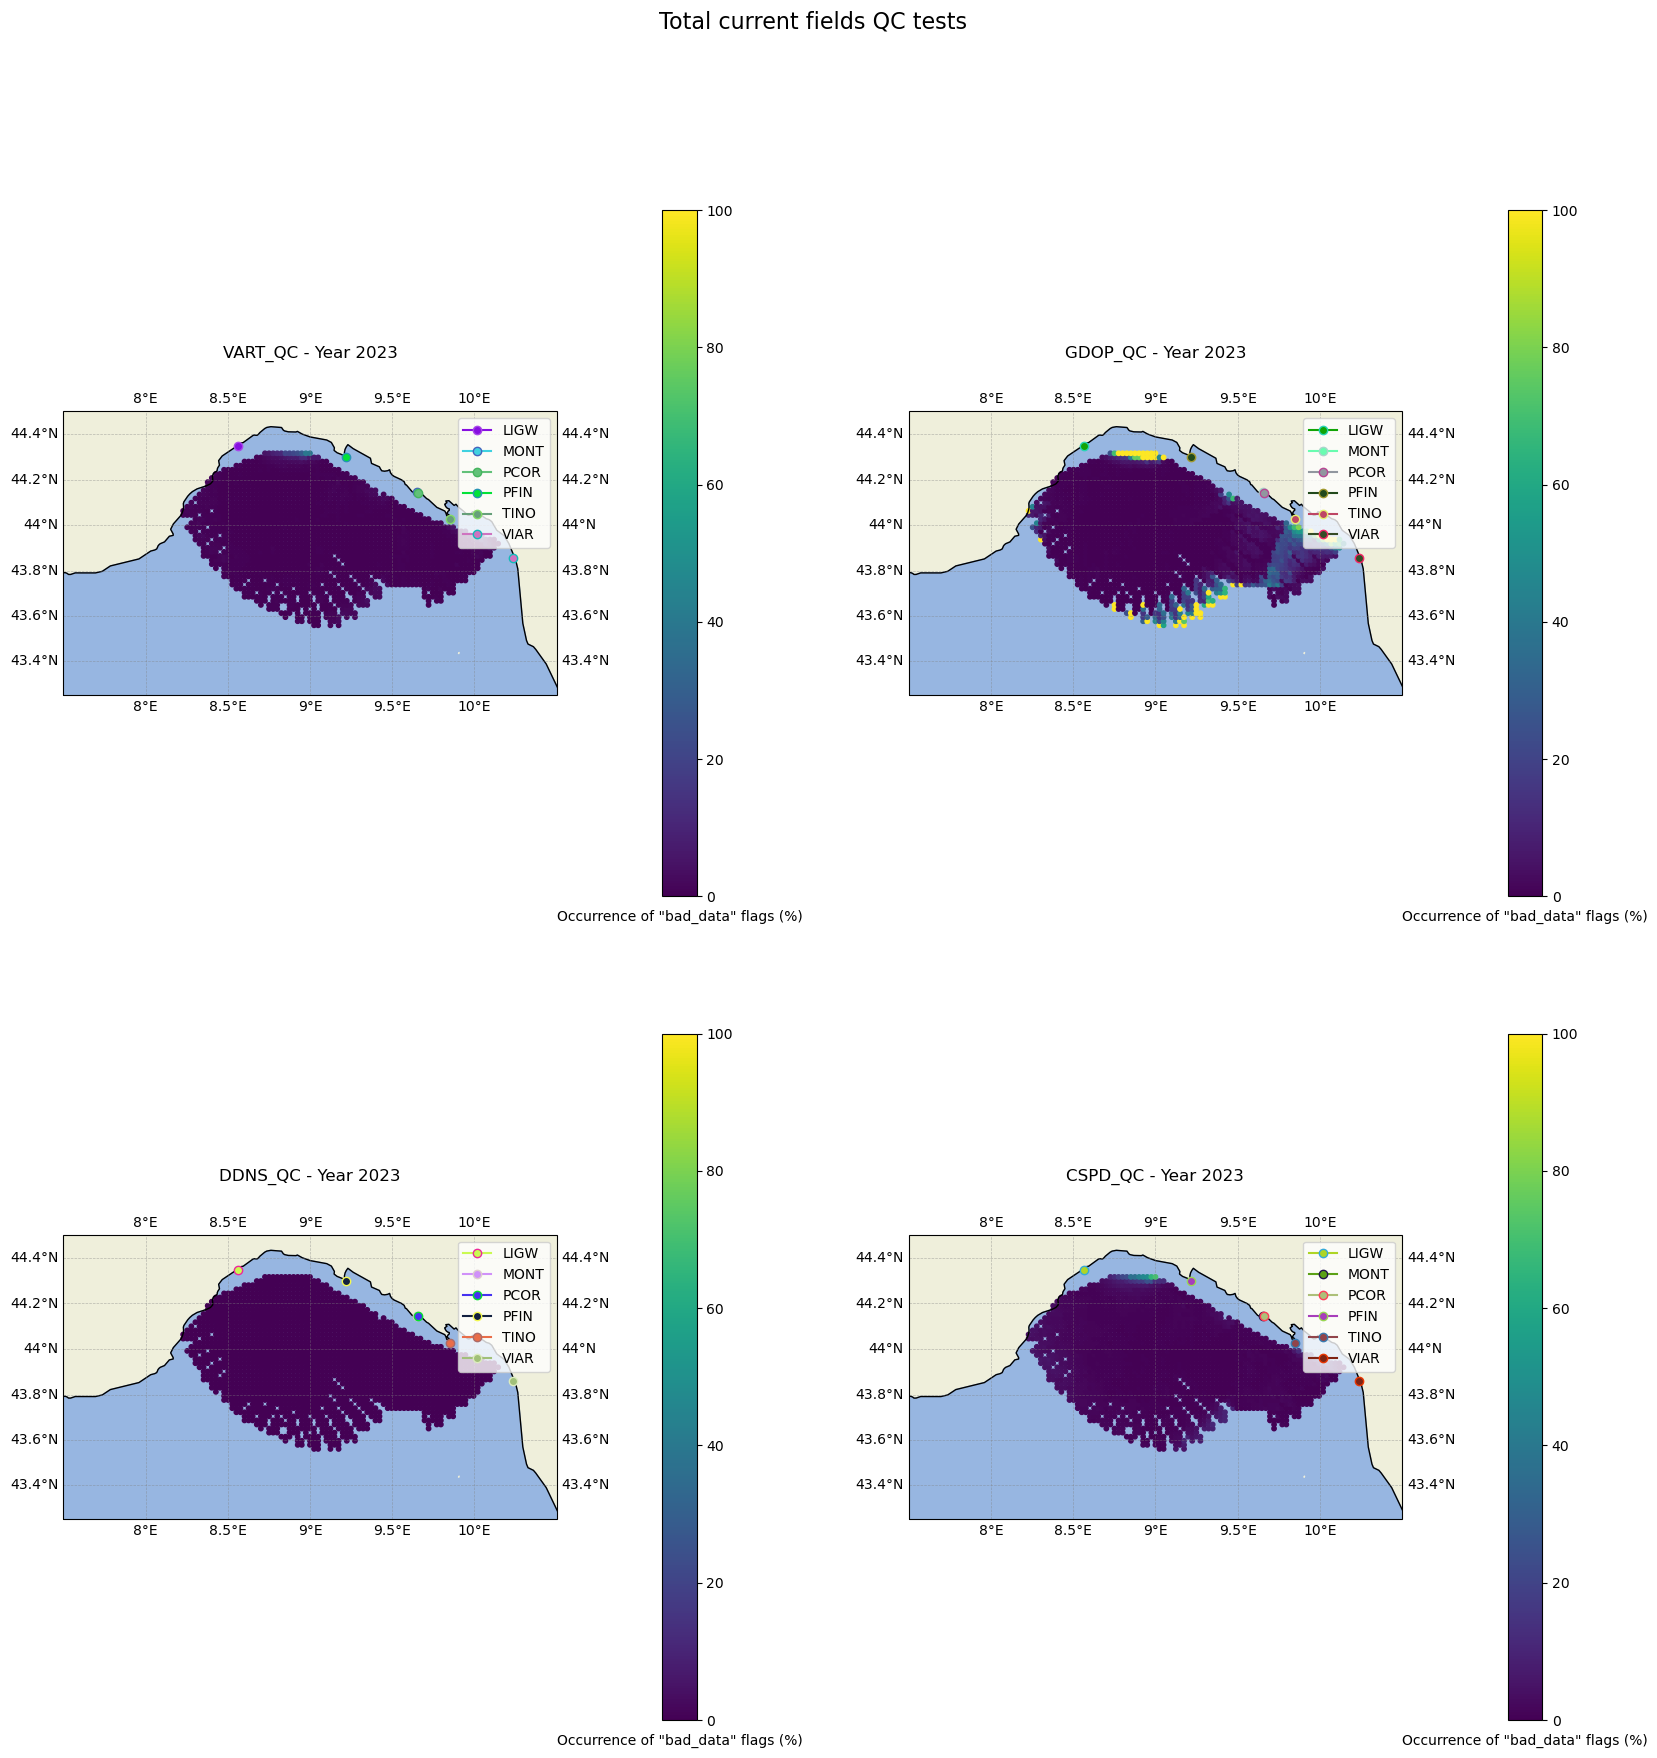

In [21]:
cmap = 'viridis'
norm = colors.Normalize(vmin=0, vmax=100)

fig, axs = plt.subplots(2, 2, subplot_kw={'projection': ccrs.Mercator()}, figsize=(20, 20), dpi=100, facecolor='w', edgecolor='k')

for i, ax in enumerate(axs.flat):
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') #adding grid lines
    
    #plotting antennas
    for Rindex, site in stationData.iterrows():
        ax.plot(site['site_lon'], site['site_lat'], color=np.random.rand(3,), markeredgecolor=np.random.rand(3,), marker='o',transform=ccrs.Geodetic(),label=site['station_id'])#add points
    
    extent = [networkData.iloc[0]['geospatial_lon_min'],networkData.iloc[0]['geospatial_lon_max'],networkData.iloc[0]['geospatial_lat_min'],networkData.iloc[0]['geospatial_lat_max']] #minX,maxX,#minY,maxY
    
    ax.legend()#add legend
    ax.add_feature(cfeature.LAND)
    ax.add_feature(cfeature.OCEAN)
    ax.add_feature(cfeature.COASTLINE)
    ax.set_extent(extent)#personalized limits
    
    X, Y = np.meshgrid(percOcc[i]['LONGITUDE'].values, percOcc[i]['LATITUDE'].values)
    
    ax.scatter(X, Y, c=percOcc[i].data[0,:,:], cmap=cmap, norm=norm, marker='o', s=10, transform=ccrs.PlateCarree())
    
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    # sm = plt.cm.ScalarMappable(cmap=cmap)
    plt.colorbar(sm,ax=ax, orientation='vertical', pad=0.15).ax.set_xlabel('Occurrence of "bad_data" flags (%)', labelpad=10, )
    
    ax.set_title(qcV[i] + ' - Year ' + str(year), pad=25)
    
fig.suptitle('Total current fields QC tests', fontsize=16)


### 4.2. Radial current fields <a id="section_4_2"></a>

In this section we'll check the impact of the QC tests as they are operationally applied to the radial velocity field data produced by your HFR network. In particular, the yearly percentage occurrence of "bad_data" flags on the radial velocity fields will be displayed per each QC test per each radial site, in order to allow you to assess how effective the thresholds you chose for the QC tests are.

#### 4.2.1. Load data from the EU HFR NODE THREDDS Data Server <a id="sub_section_4_2_1"></a>

Now we load the radial velocity datasets for year 2023 of each radial station of your HFR network from the EU HFR NODE THREDDS Data Server. Please run the `next cell`:

In [22]:
# Set the year to be loaded
year = 2023

# Set the yearly temporal extent
tStart = dt.datetime.strptime(str(year) + '-01-01 00:00:00','%Y-%m-%d %H:%M:%S')
tEnd = dt.datetime.strptime(str(year) + '-12-31 23:59:00','%Y-%m-%d %H:%M:%S')

# Create an empty list for containing the radial datasets
Rds = []

# Loop through radial sites
for Rindex, site in stationData.iterrows():
    # Get the TDS URL of the dataset
    OpenDAPdataUrl = site['SDC_OpenDAP_data_url']

    # Read aggregated total dataset from THREDDS catalog via OpenDAP
    Rds.append(xr.open_dataset(OpenDAPdataUrl, decode_times=True).sel(TIME=slice(tStart,tEnd)))


#### 4.2.2. Evaluate the yearly percentage occurrence of "bad_data" <a id="sub_section_4_2_2"></a>

First of all let's check the current operational thresholds for radial velocity fields QC tests, i.e. Temporal derivative, Median filter, Average radial bearing, Velocity test, Radial Count and Over-water test. Please run the `next cell`:

In [23]:
stationData[['station_id', 'radial_QC_variance_threshold', 'radial_QC_temporal_derivative_threshold', 'radial_QC_median_filter_RCLim', 'radial_QC_median_filter_AngLim', 'radial_QC_median_filter_CurLim', 'radial_QC_average_radial_bearing_min', 'radial_QC_average_radial_bearing_max', 'radial_QC_velocity_threshold']]

station_id  radial_QC_variance_threshold  radial_QC_temporal_derivative_threshold  radial_QC_median_filter_RCLim  radial_QC_median_filter_AngLim  radial_QC_median_filter_CurLim  radial_QC_average_radial_bearing_min  radial_QC_average_radial_bearing_max  radial_QC_velocity_threshold
118       LIGW                           1.0                                      1.0                            5.0                            30.0                             1.0                                   0.0                                 360.0                           1.2
143       MONT                           1.0                                      1.0                            5.0                            30.0                             1.0                                 170.0                                 190.0                           1.2
164       PCOR                           1.0                                      1.0                            5.0                            30.0                             1.0                                 180.0                                 190.0                           1.2
168       PFIN                           1.0                                      1.0                            5.0                            30.0                             1.0                                 155.0                                 185.0                           1.2
251       TINO                           1.0                                      1.0                            5.0                            30.0                             1.0                                 175.0                                 210.0                           1.2
264       VIAR                           1.0                                      1.0                            5.0                            30.0                             1.0                                 240.0                                 270.0                           1.2

Now we'll evaluate the yearly percentage occurrence of "bad_data" flags on the radial velocity fields per each QC test per each radial site. Please run the `next cell`:

In [24]:
# Create the list of interested QC variables present in the dataset
qcV = ['VART_QC','MDFL_QC','AVRB_QC','CSPD_QC', 'RDCT_QC', 'OWTR_QC']

# Create an empty dictionary for containing the percentage occurrence matrices for each radial site
radSiteQC = {}

# Loop through radial sites
for rad in Rds:
    # Create an empty list for containing the percentage occurrence matrices for the QC variables
    percOcc = []
    for v in qcV:
        # Create a mask for non-NaN values
        nonNanMask = ~np.isnan(rad[v])

        # Count occurrences of value 4 along the TIME dimension
        count4 = (rad[v] == 4).sum(dim='TIME')

        # Count non-NaN occurrences along the TIME dimension
        countNonNan = nonNanMask.sum(dim='TIME')

        # Divide the counts to get the percentage occurrence
        percOcc.append((count4 / countNonNan) *100)
        
    # Insert the result in the dictionary as the key of the current radial site
    radSiteQC[rad.attrs['platform_code']] = percOcc


And now we'll plot the yearly percentage occurrence of "bad_data" flags on the radial velocity fields per each QC test per each radial site. Please run the `next cell`:

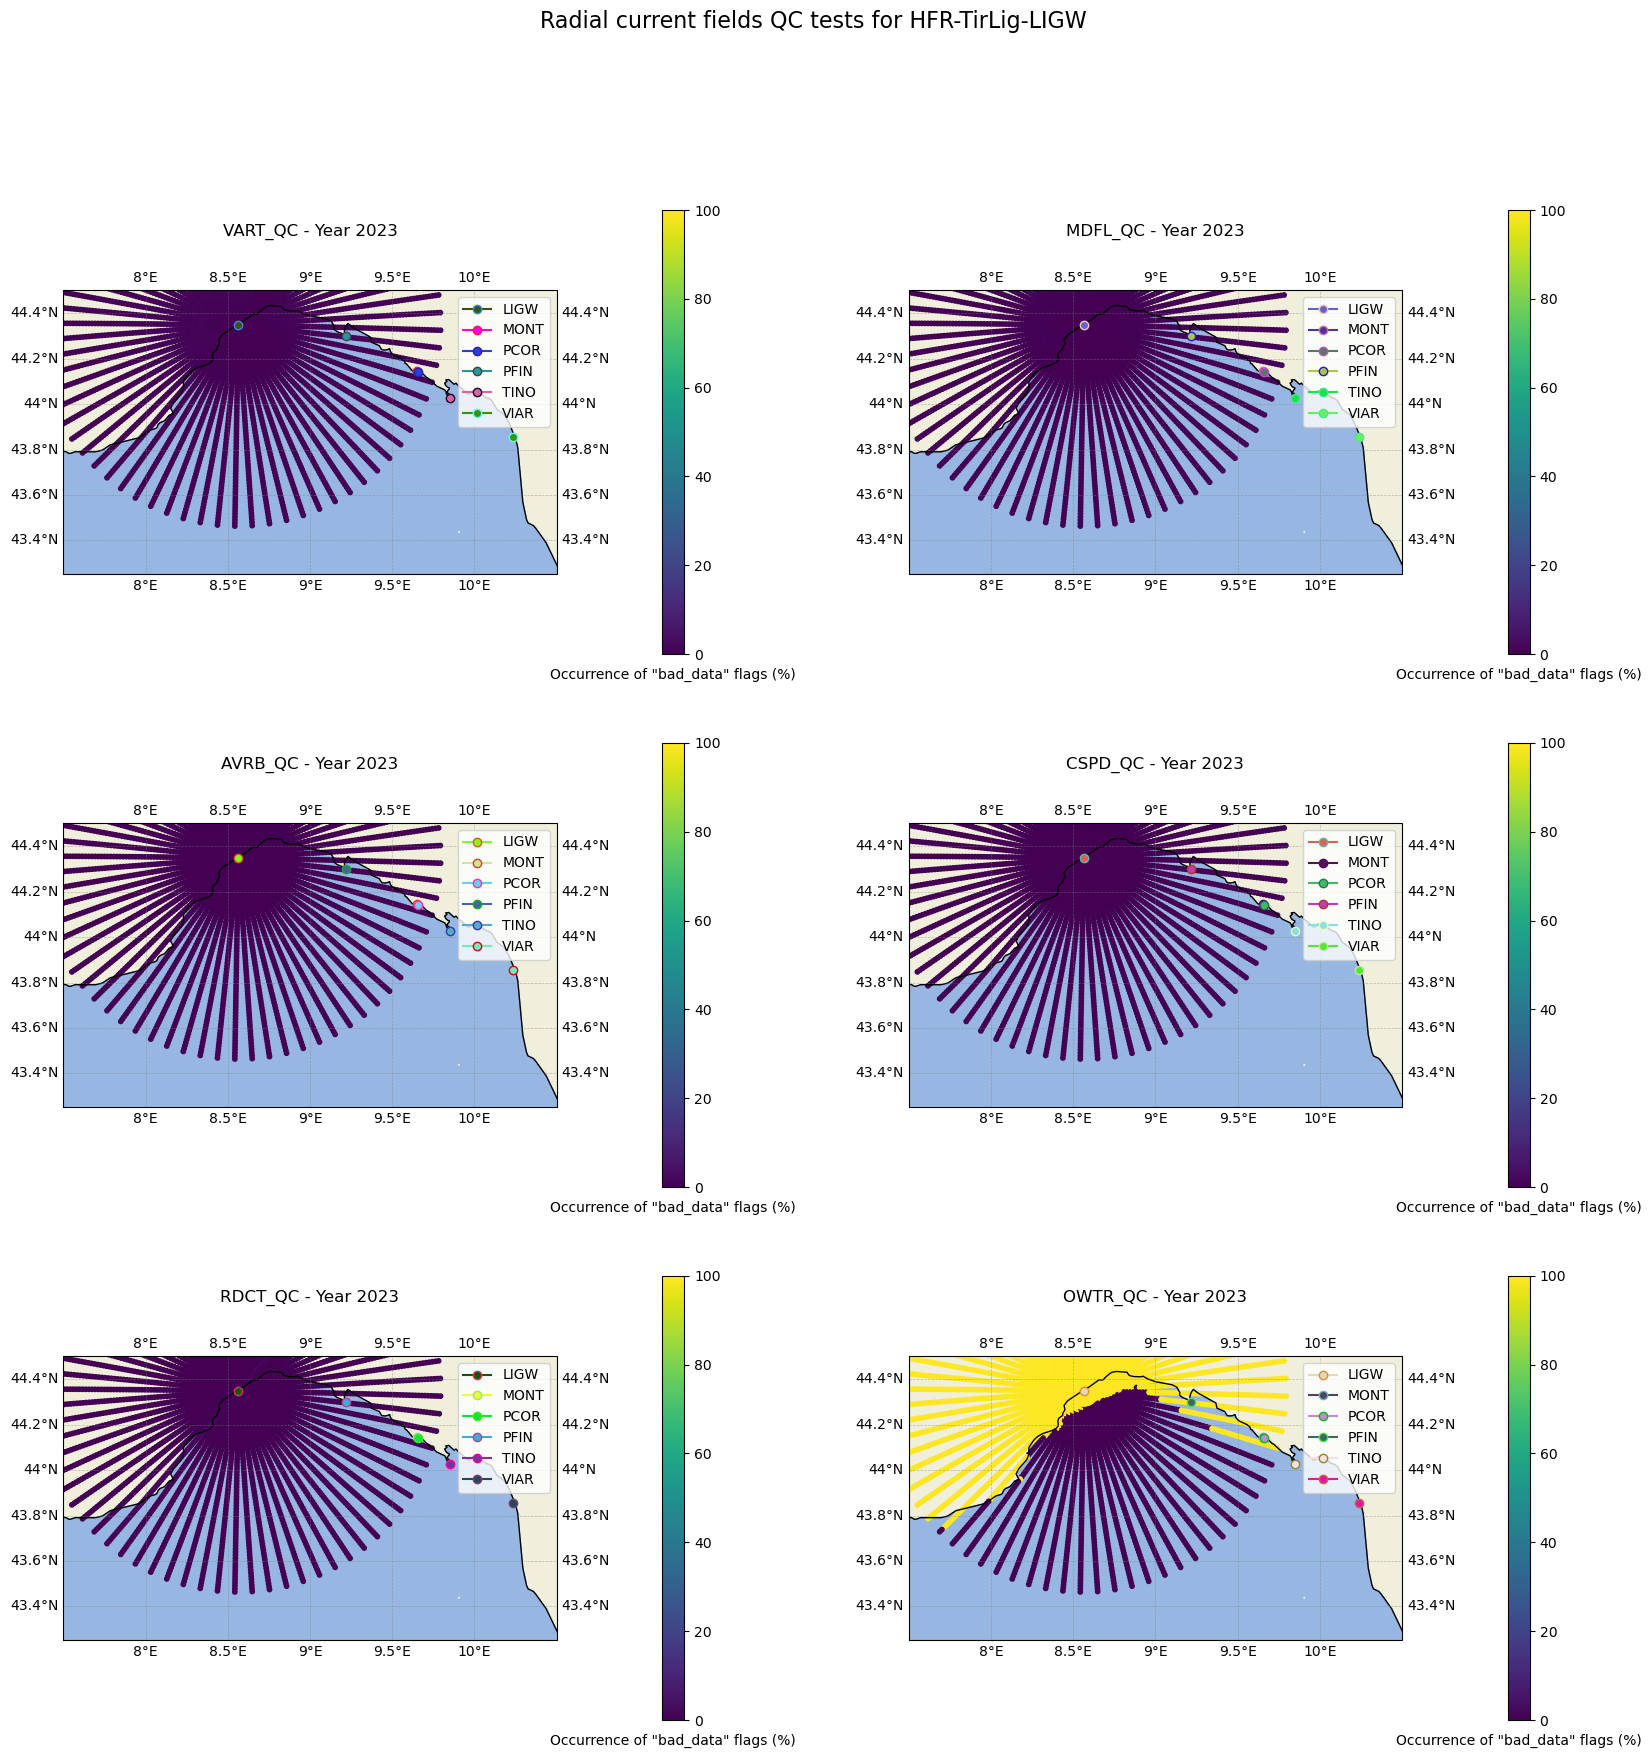

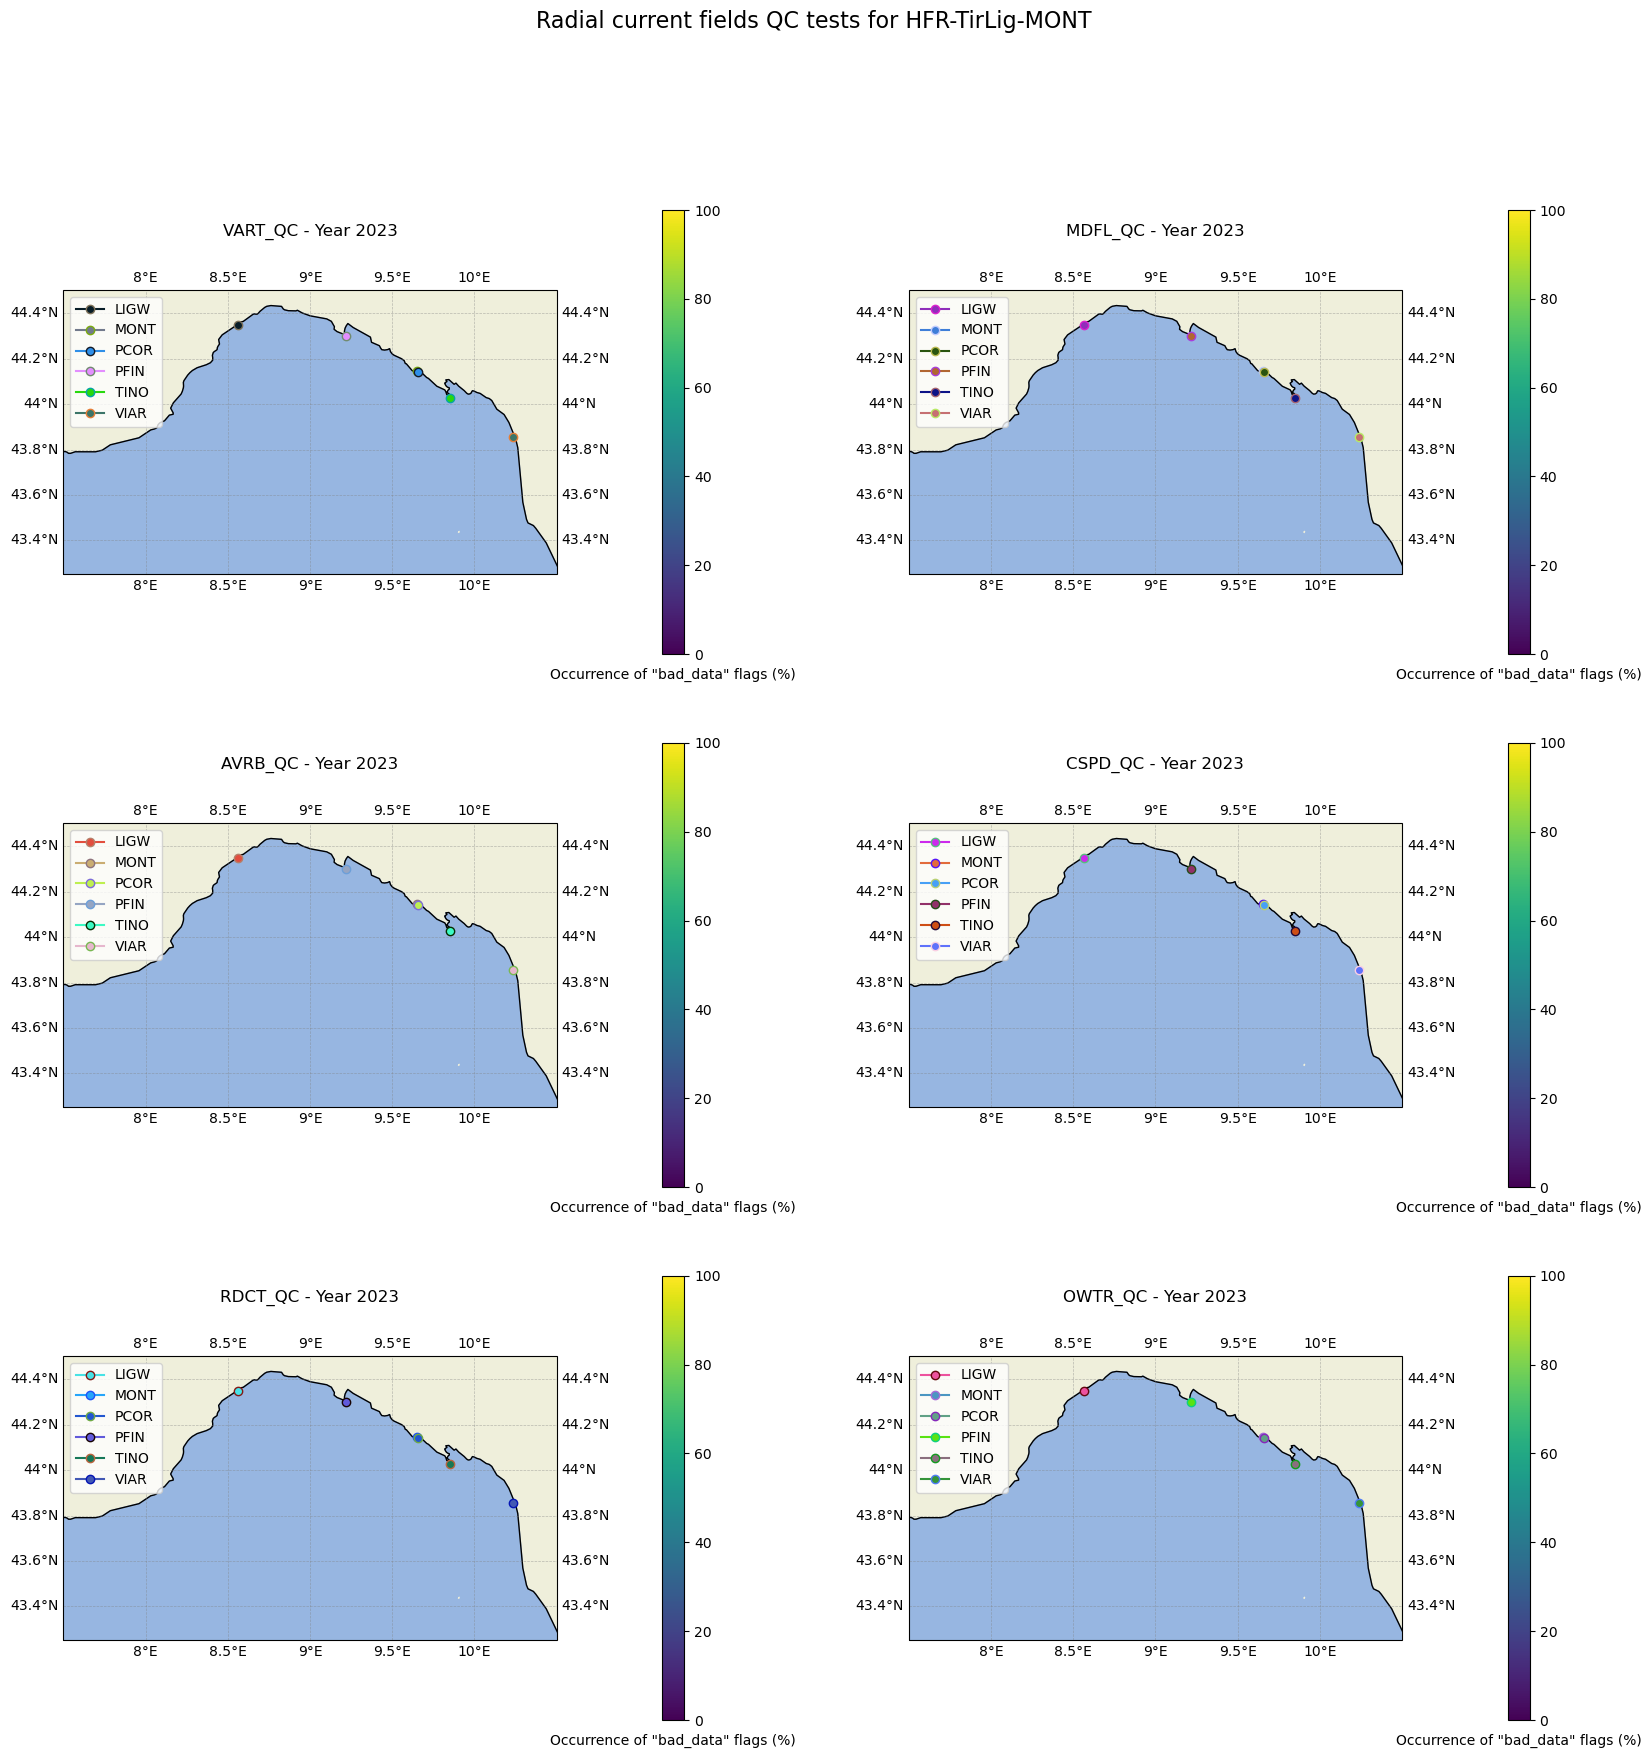

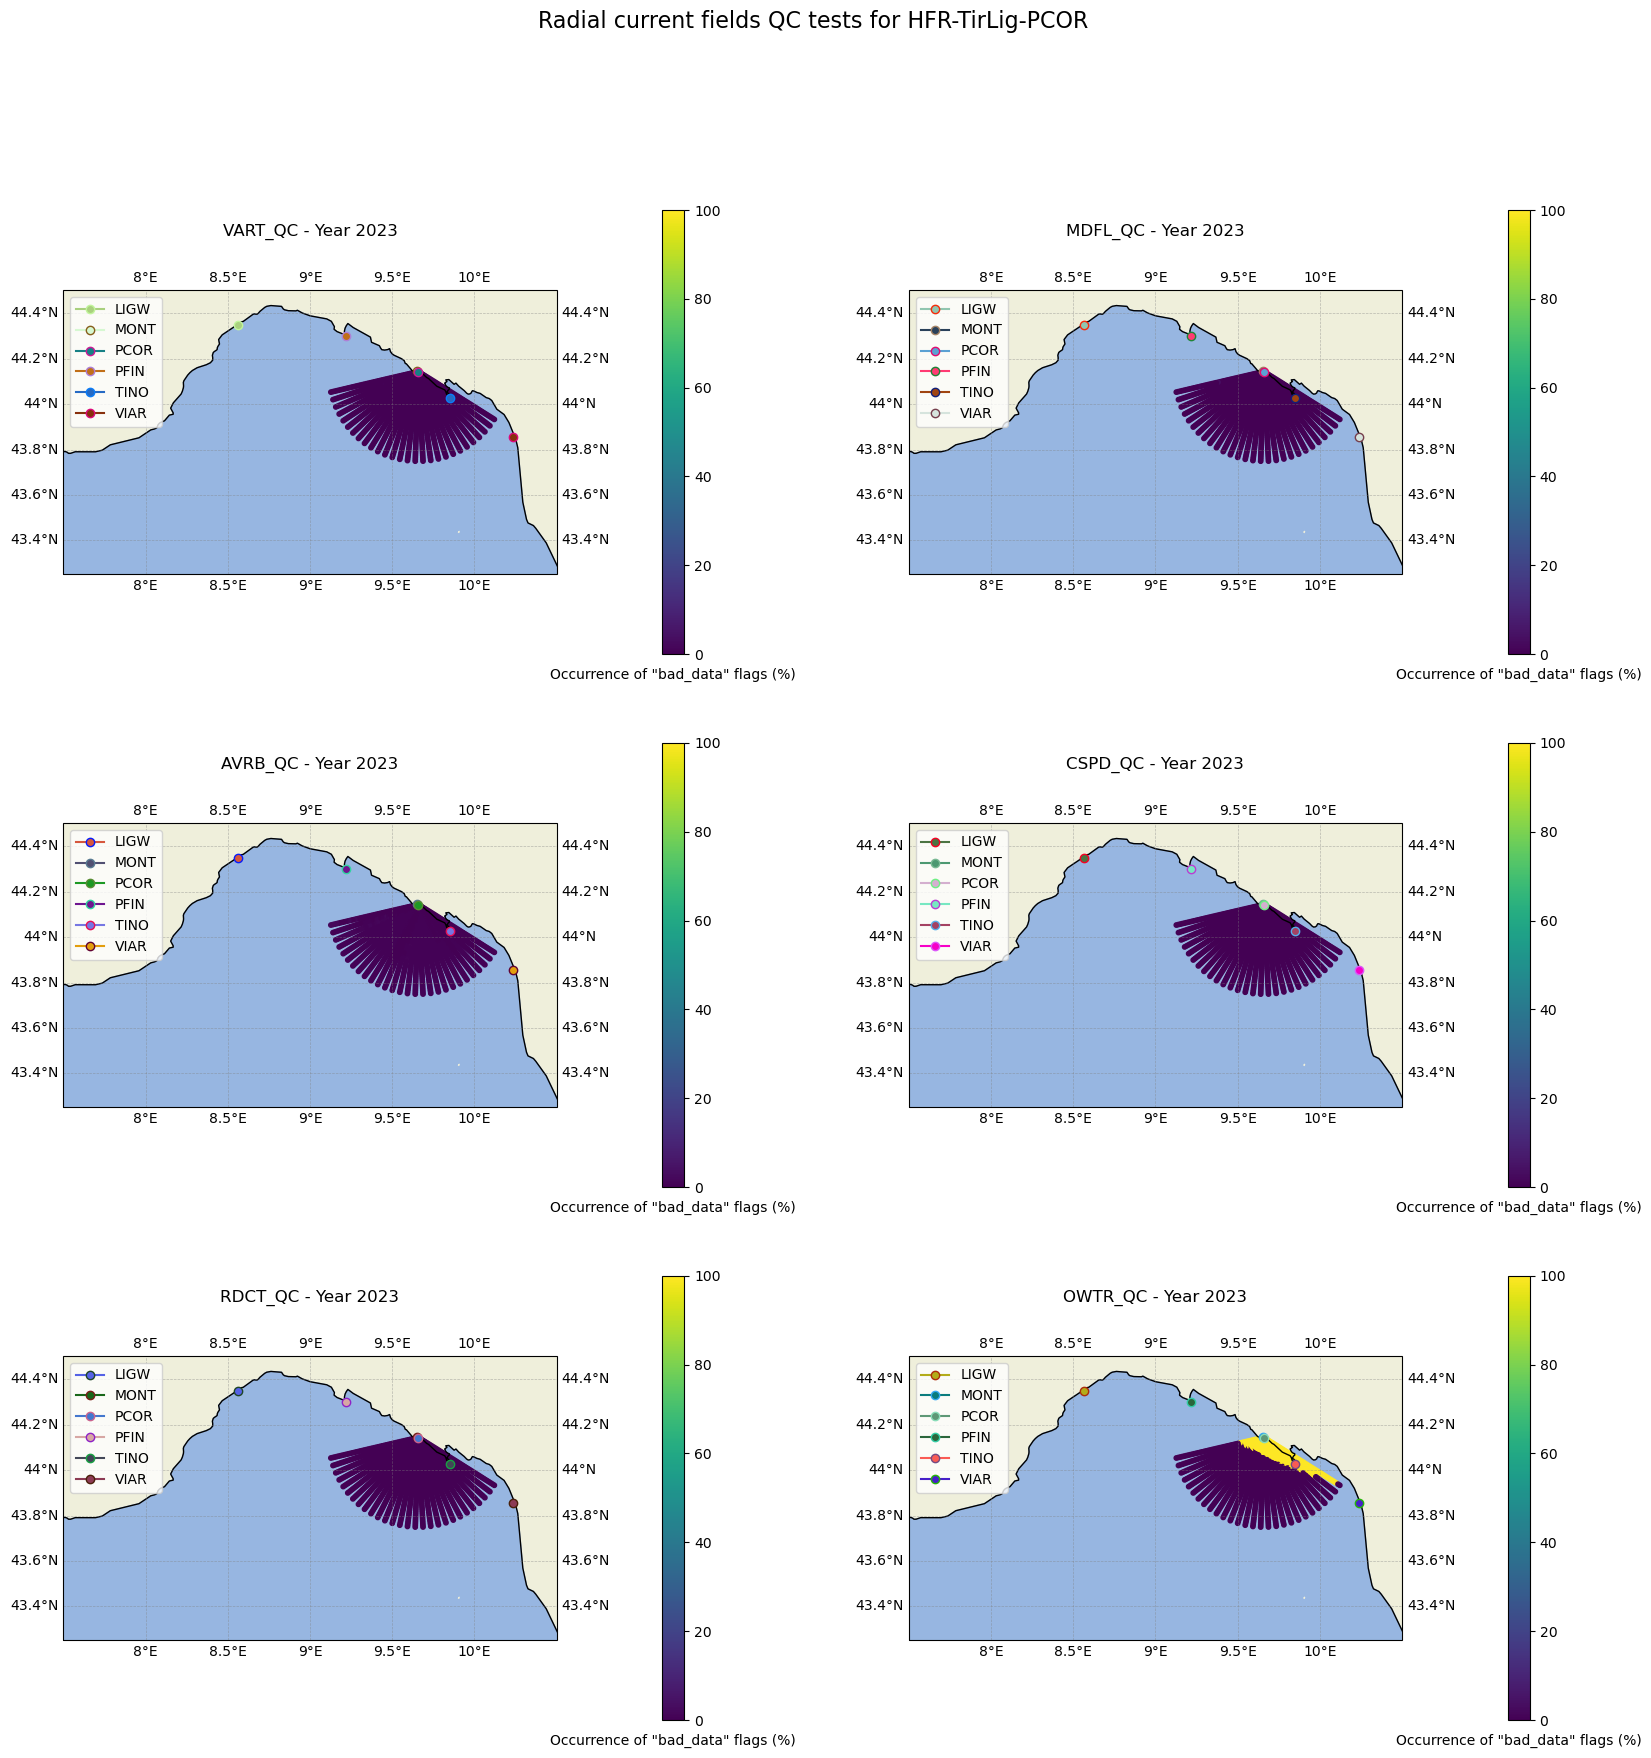

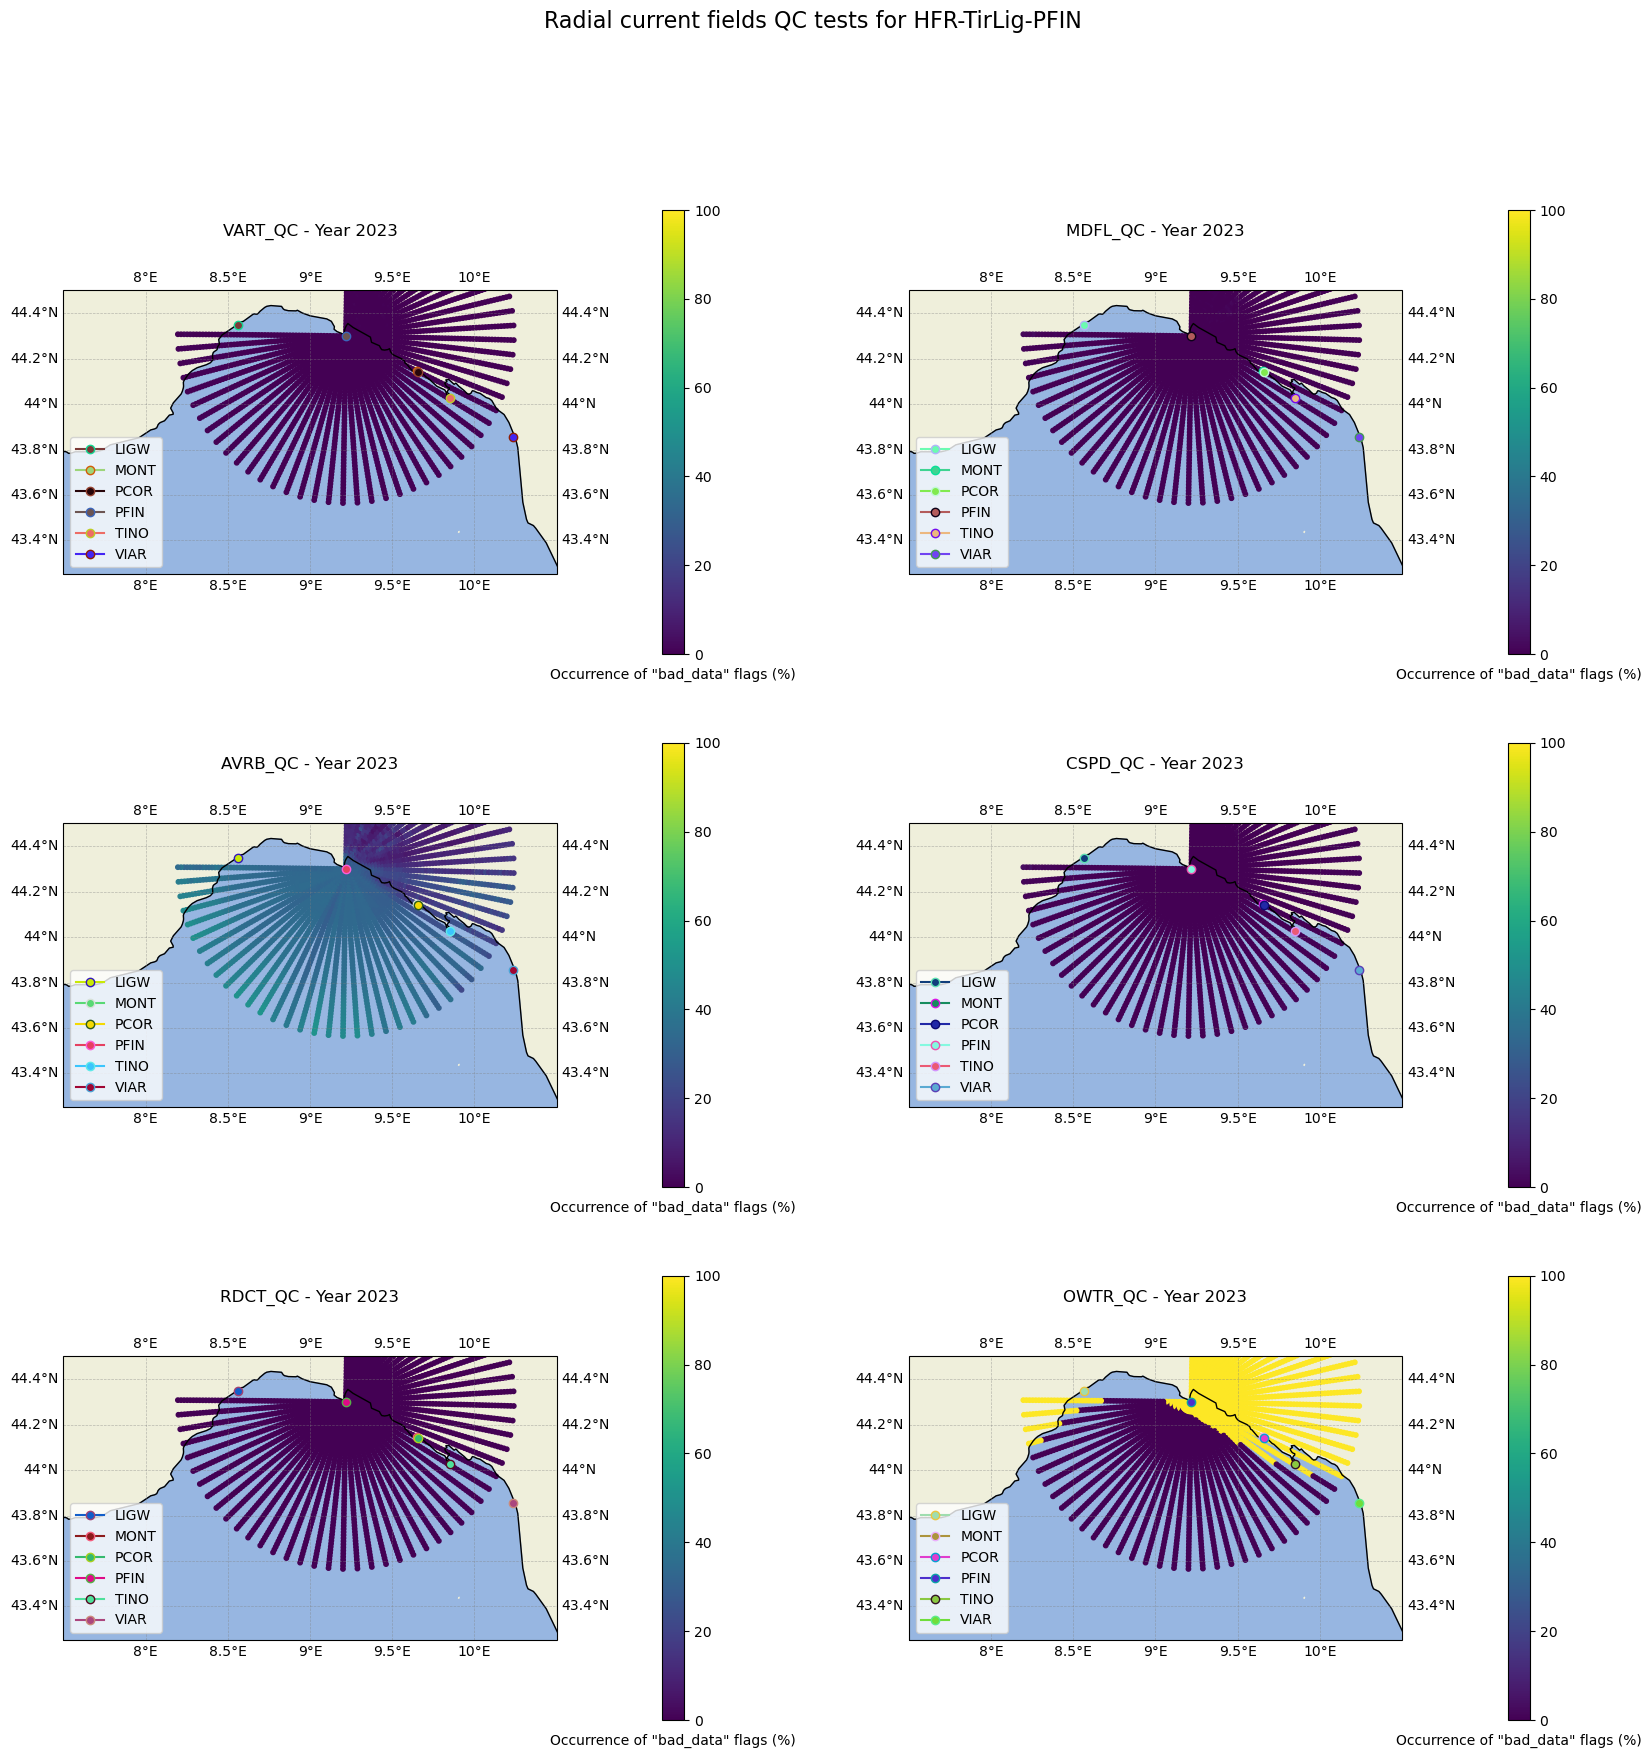

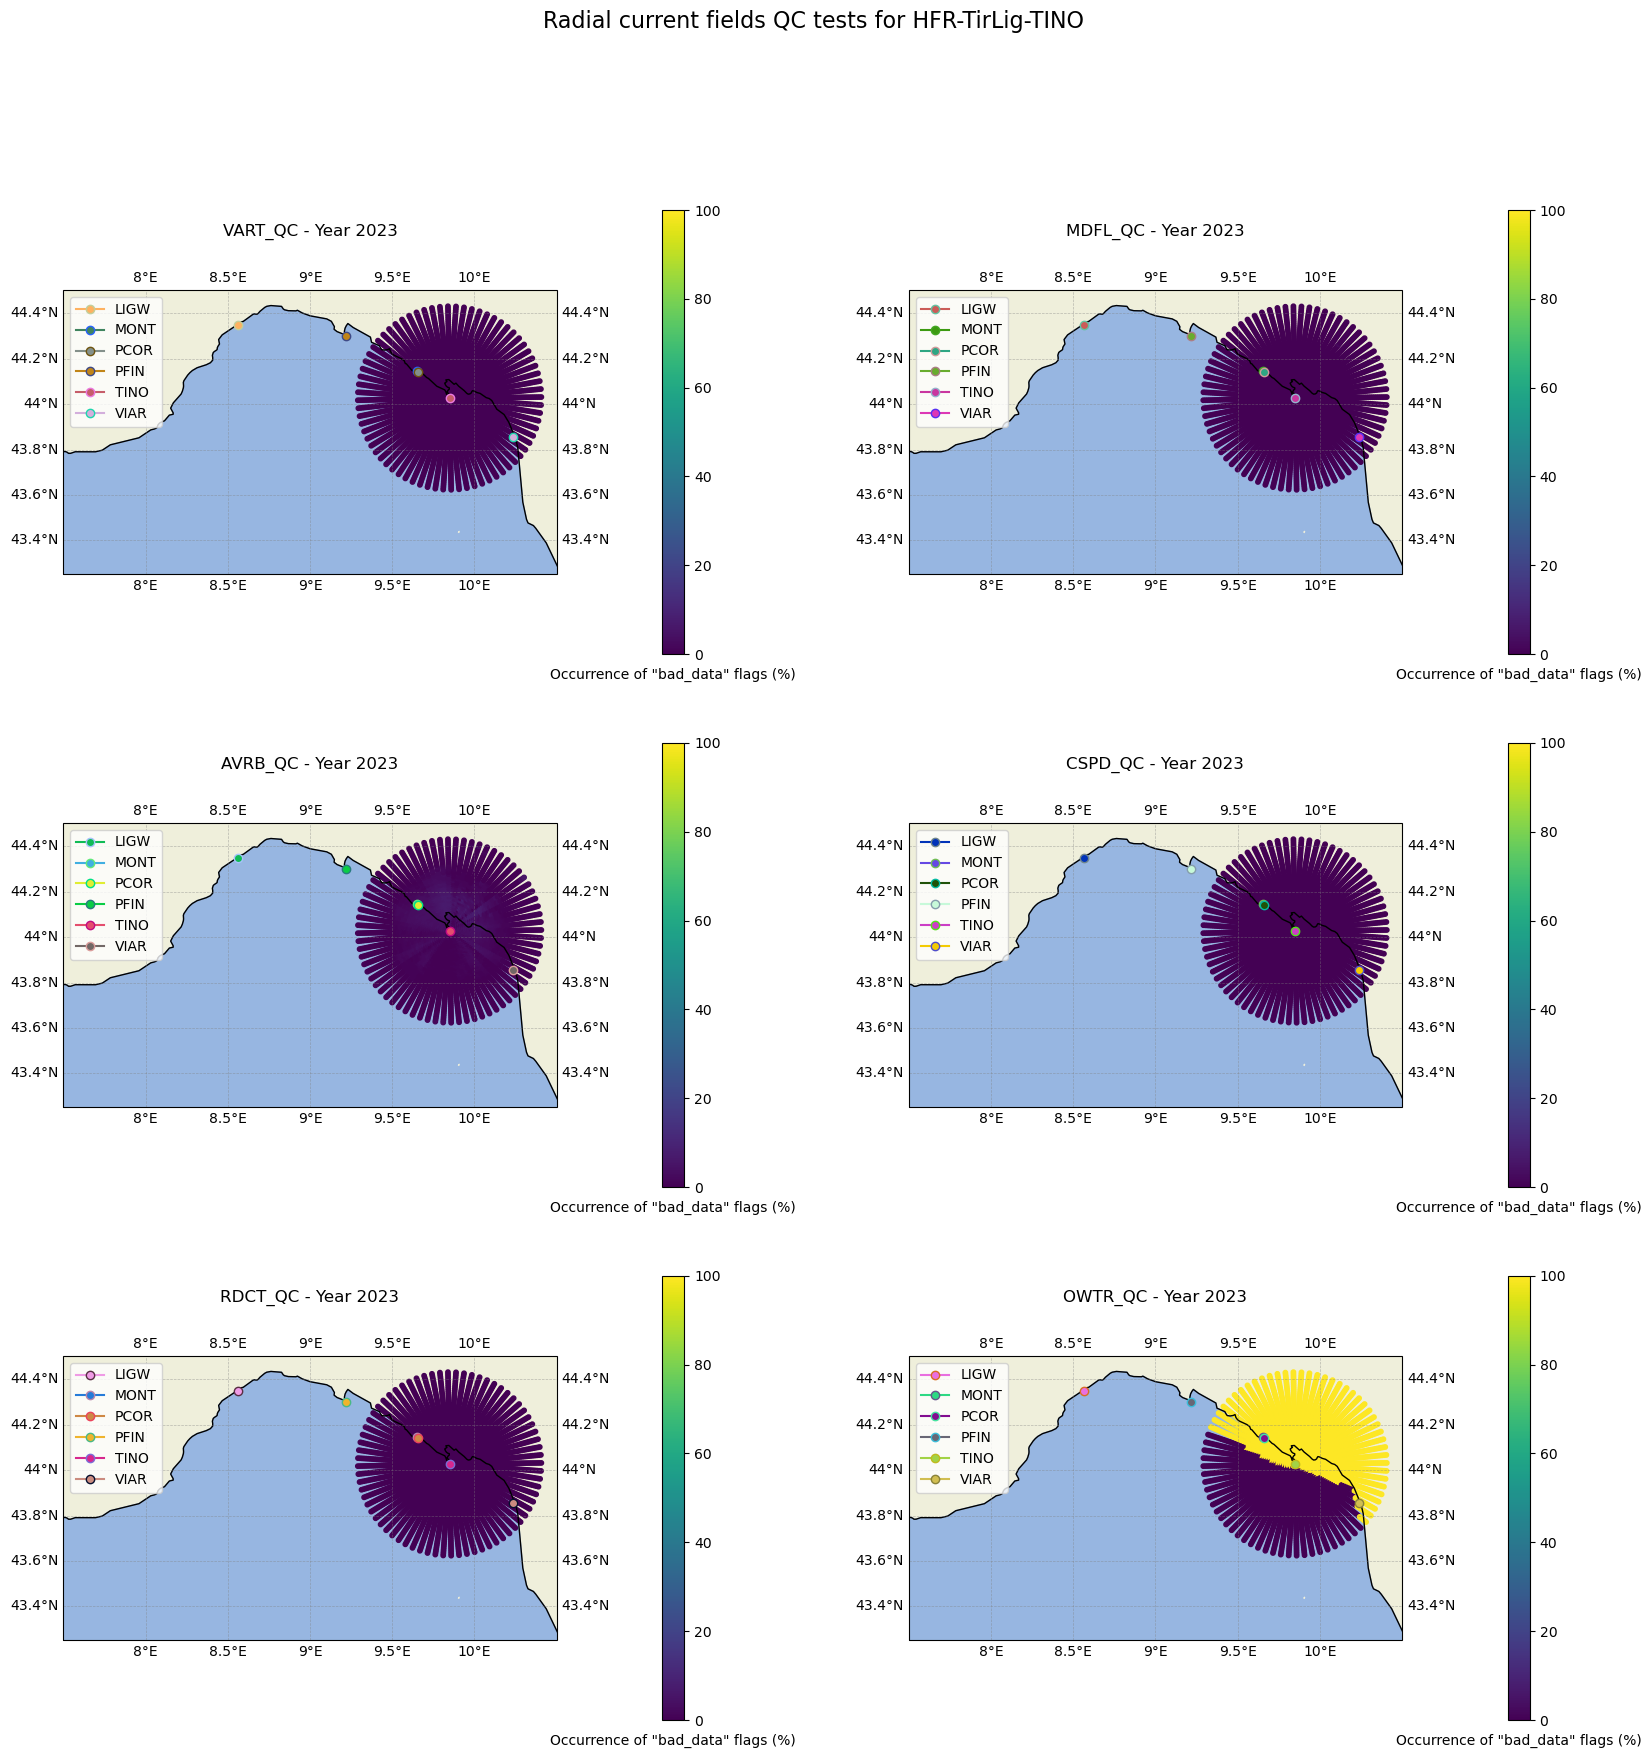

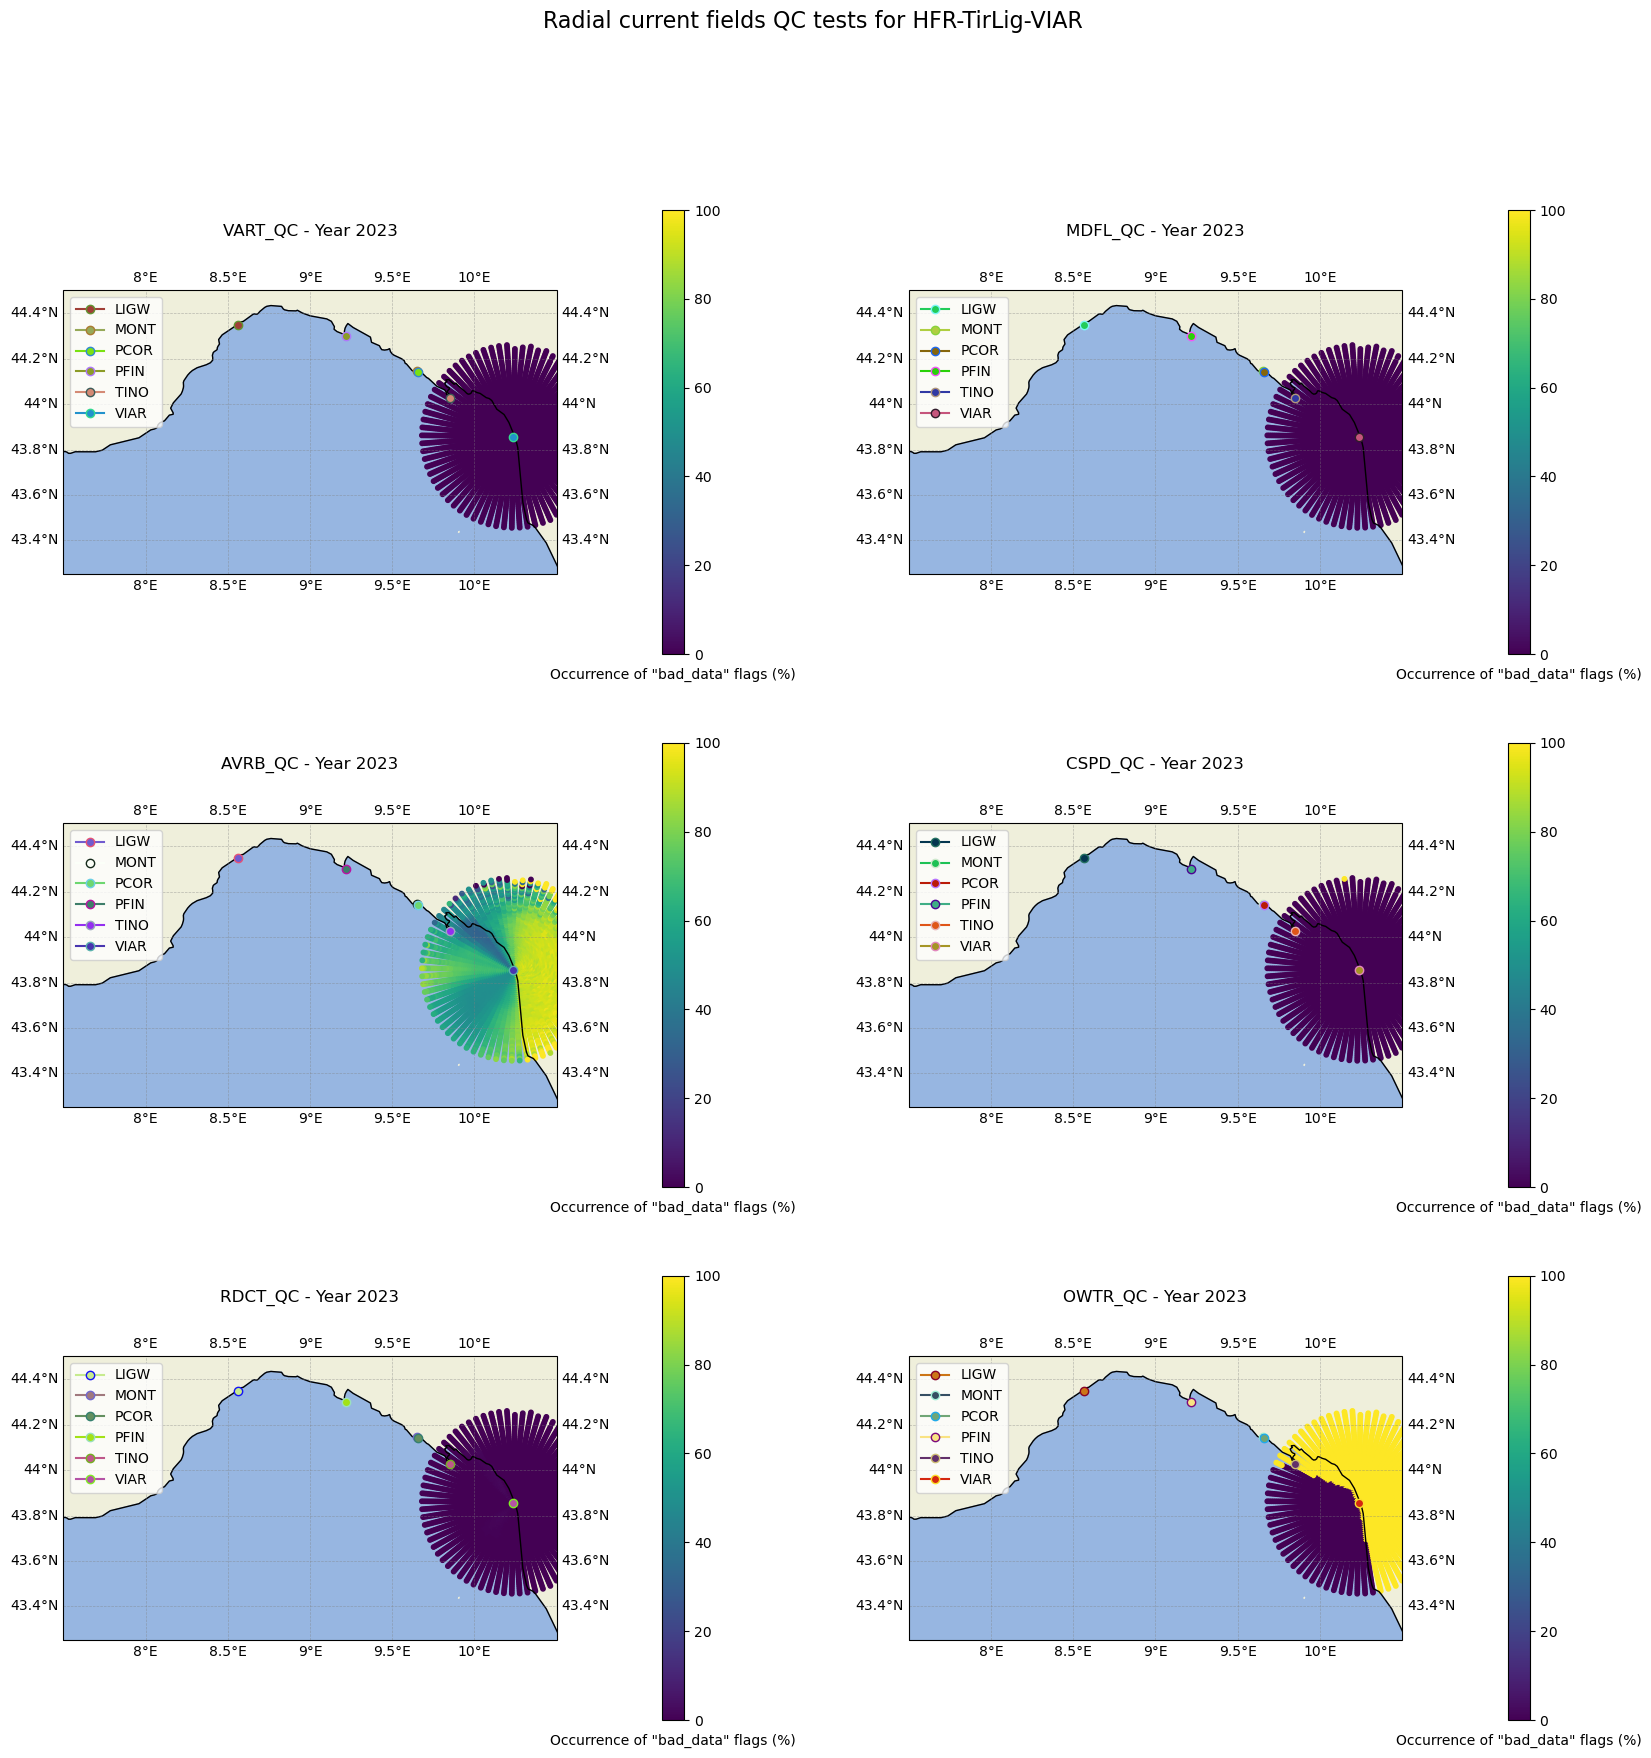

In [25]:
cmap = 'viridis'
norm = colors.Normalize(vmin=0, vmax=100)

# Loop through radial sites
for key,val in radSiteQC.items():
    fig, axs = plt.subplots(3, 2, subplot_kw={'projection': ccrs.Mercator()}, figsize=(20, 20), dpi=100, facecolor='w', edgecolor='k')

    for i, ax in enumerate(axs.flat):
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--') #adding grid lines

        #plotting antennas
        for Rindex, site in stationData.iterrows():
            ax.plot(site['site_lon'], site['site_lat'], color=np.random.rand(3,), markeredgecolor=np.random.rand(3,), marker='o',transform=ccrs.Geodetic(),label=site['station_id'])#add points

        extent = [networkData.iloc[0]['geospatial_lon_min'],networkData.iloc[0]['geospatial_lon_max'],networkData.iloc[0]['geospatial_lat_min'],networkData.iloc[0]['geospatial_lat_max']] #minX,maxX,#minY,maxY

        ax.legend()#add legend
        ax.add_feature(cfeature.LAND)
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.COASTLINE)
        ax.set_extent(extent)#personalized limits

        if 'RNGE' in val[0].dims:
            X, Y = val[i]['LONGITUDE'].values, val[i]['LATITUDE'].values
        else:
            X, Y = np.meshgrid(val[i]['LONGITUDE'].values, val[i]['LATITUDE'].values)

        ax.scatter(X, Y, c=val[i].data[0,:,:], cmap=cmap, norm=norm, marker='o', s=10, transform=ccrs.PlateCarree())

        sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
        # sm = plt.cm.ScalarMappable(cmap=cmap)
        plt.colorbar(sm,ax=ax, orientation='vertical', pad=0.15).ax.set_xlabel('Occurrence of "bad_data" flags (%)', labelpad=10, )

        ax.set_title(qcV[i] + ' - Year ' + str(year), pad=25)

    fig.suptitle('Radial current fields QC tests for ' + key, fontsize=16)


<div class="alert alert-block alert-warning">
<b>SET THE OPTIMAL THRESHOLDS FOR THE QC TESTS</b>

***  
**Based on this exercise, you can now choose the optimal threshold for QC tests to be applied for your HFR network.
</div>